## Imports

In [38]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import librosa
import librosa.display
import random
import shutil
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import kagglehub
from IPython.display import display, HTML

In [39]:
# Set random seeds for reproducibility
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

## Preprocessing the dataset && applying the EDA

In [40]:
class ViolenceDatasetPipeline:
    def __init__(self, dataset_path=None, sample_rate=22050, n_mfcc=13, 
                 frame_sample_rate=5, img_size=(224, 224)):
        """
        Initialize the Violence Dataset Pipeline
        
        Args:
            dataset_path: Path to the dataset
            sample_rate: Audio sample rate for processing
            n_mfcc: Number of MFCC coefficients to extract
            frame_sample_rate: Sample every nth frame from videos
            img_size: Target image size for resizing frames
        """
        if dataset_path is None:
            self.dataset_path = kagglehub.dataset_download("mohamedmustafa/real-life-violence-situations-dataset")
        else:
            self.dataset_path = dataset_path
            
        self.sample_rate = sample_rate
        self.n_mfcc = n_mfcc
        self.frame_sample_rate = frame_sample_rate
        self.img_size = img_size
        
        # Dataset structure/paths
        self.violence_path = os.path.join(self.dataset_path, "Real Life Violence Dataset", "Violence")
        self.non_violence_path = os.path.join(self.dataset_path, "Real Life Violence Dataset", "NonViolence")
        
        # Data containers
        self.video_paths = []
        self.labels = []
        self.metadata = None
        self.train_data = None
        self.val_data = None
        self.test_data = None
        
        # Output paths
        self.processed_data_path = "processed_data"
        os.makedirs(self.processed_data_path, exist_ok=True)
        
        print(f"Dataset initialized at: {self.dataset_path}")

    def collect_video_paths(self):
        """Collect all video paths and their corresponding labels"""
        # Violence videos (label 1)
        violence_videos = [os.path.join(self.violence_path, f) for f in os.listdir(self.violence_path) 
                          if f.endswith(('.mp4', '.avi'))]
        
        # Non-violence videos (label 0)
        non_violence_videos = [os.path.join(self.non_violence_path, f) for f in os.listdir(self.non_violence_path) 
                              if f.endswith(('.mp4', '.avi'))]
        
        self.video_paths = violence_videos + non_violence_videos
        self.labels = [1] * len(violence_videos) + [0] * len(non_violence_videos)
        
        # Create metadata DataFrame
        self.metadata = pd.DataFrame({
            'path': self.video_paths,
            'label': self.labels,
            'class': ['Violence' if l == 1 else 'NonViolence' for l in self.labels]
        })
        
        print(f"Total videos collected: {len(self.video_paths)}")
        print(f"- Violence videos: {len(violence_videos)}")
        print(f"- Non-violence videos: {len(non_violence_videos)}")
        
        return self.metadata
    
    def check_video_integrity(self, video_path):
        """Check if a video file is readable and has frames"""
        try:
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                return False
            
            ret, frame = cap.read()
            if not ret:
                return False
                
            cap.release()
            return True
        except:
            return False
    
    def extract_audio(self, video_path, output_path=None):
        """Extract audio from video and save it as WAV"""
        if output_path is None:
            # Create output path based on video name
            video_name = os.path.basename(video_path).split('.')[0]
            output_path = os.path.join(self.processed_data_path, 'audio', f"{video_name}.wav")
            
            # Ensure directory exists
            os.makedirs(os.path.dirname(output_path), exist_ok=True)
        
        try:
            # Use ffmpeg through os command to extract audio
            os.system(f"ffmpeg -i '{video_path}' -q:a 0 -map a '{output_path}' -y -loglevel quiet")
            
            # Verify audio was extracted
            if os.path.exists(output_path) and os.path.getsize(output_path) > 0:
                return output_path
            else:
                return None
        except:
            return None
    
    def extract_video_features(self, video_path, output_dir=None, max_frames=20):
        """
        Extract frames and metadata from video
        
        Args:
            video_path: Path to video file
            output_dir: Directory to save frames
            max_frames: Maximum number of frames to extract
            
        Returns:
            Dictionary with video features
        """
        if output_dir is None:
            video_name = os.path.basename(video_path).split('.')[0]
            output_dir = os.path.join(self.processed_data_path, 'frames', video_name)
            os.makedirs(output_dir, exist_ok=True)
        
        features = {}
        
        try:
            cap = cv2.VideoCapture(video_path)
            
            # Get video metadata
            features['frame_count'] = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            features['fps'] = cap.get(cv2.CAP_PROP_FPS)
            features['width'] = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            features['height'] = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            features['duration'] = features['frame_count'] / features['fps'] if features['fps'] > 0 else 0
            
            # Sample frames
            saved_frames = []
            frame_interval = max(1, features['frame_count'] // max_frames)
            
            frame_idx = 0
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                
                if frame_idx % frame_interval == 0:
                    # Resize frame
                    resized_frame = cv2.resize(frame, self.img_size)
                    
                    # Save frame
                    frame_path = os.path.join(output_dir, f"frame_{frame_idx:04d}.jpg")
                    cv2.imwrite(frame_path, resized_frame)
                    saved_frames.append(frame_path)
                    
                    if len(saved_frames) >= max_frames:
                        break
                
                frame_idx += 1
            
            cap.release()
            
            features['sampled_frames'] = saved_frames
            features['frame_count_actual'] = len(saved_frames)
            
            return features
        
        except Exception as e:
            print(f"Error processing video {video_path}: {str(e)}")
            return None
    
    def extract_audio_features(self, audio_path):
        """
        Extract audio features (MFCCs, spectrograms) from audio file
        
        Args:
            audio_path: Path to audio file
            
        Returns:
            Dictionary with audio features
        """
        if not os.path.exists(audio_path):
            return None
            
        try:
            # Load audio with librosa
            y, sr = librosa.load(audio_path, sr=self.sample_rate)
            
            features = {}
            
            # Basic audio properties
            features['duration'] = librosa.get_duration(y=y, sr=sr)
            features['sample_rate'] = sr
            
            # Extract MFCC features
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=self.n_mfcc)
            features['mfcc'] = mfccs
            features['mfcc_mean'] = np.mean(mfccs, axis=1)
            features['mfcc_std'] = np.std(mfccs, axis=1)
            
            # Extract mel spectrogram
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
            features['mel_spectrogram'] = mel_spec
            
            # Extract chroma features
            chroma = librosa.feature.chroma_stft(y=y, sr=sr)
            features['chroma'] = chroma
            features['chroma_mean'] = np.mean(chroma, axis=1)
            
            # Zero crossing rate
            zcr = librosa.feature.zero_crossing_rate(y)
            features['zcr_mean'] = np.mean(zcr)
            features['zcr_std'] = np.std(zcr)
            
            # Spectral centroid
            spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
            features['spectral_centroid_mean'] = np.mean(spectral_centroid)
            
            return features
            
        except Exception as e:
            print(f"Error extracting audio features from {audio_path}: {str(e)}")
            return None
    
    def preprocess_data(self, sample_size=None):
        """
        Preprocess the dataset by:
        1. Checking video integrity
        2. Extracting audio from videos
        3. Extracting frames from videos
        4. Extracting features from audio
        
        Args:
            sample_size: Number of videos to process (for testing)
        """
        if self.metadata is None:
            self.collect_video_paths()
        
        # Sample a subset if specified
        if sample_size is not None:
            sampled_indices = random.sample(range(len(self.metadata)), min(sample_size, len(self.metadata)))
            sample_metadata = self.metadata.iloc[sampled_indices].reset_index(drop=True)
        else:
            sample_metadata = self.metadata
        
        # Create columns for processed data
        sample_metadata['valid_video'] = False
        sample_metadata['audio_path'] = None
        sample_metadata['has_audio'] = False
        sample_metadata['frames_dir'] = None
        sample_metadata['frame_count'] = 0
        sample_metadata['audio_features'] = None
        sample_metadata['video_features'] = None
        
        for idx, row in tqdm(sample_metadata.iterrows(), total=len(sample_metadata), desc="Processing videos"):
            video_path = row['path']
            
            # Check video integrity
            is_valid = self.check_video_integrity(video_path)
            sample_metadata.loc[idx, 'valid_video'] = is_valid
            
            if not is_valid:
                continue
                
            # Extract audio
            audio_path = self.extract_audio(video_path)
            sample_metadata.loc[idx, 'audio_path'] = audio_path
            sample_metadata.loc[idx, 'has_audio'] = audio_path is not None
            
            # Extract video features (frames, metadata)
            video_name = os.path.basename(video_path).split('.')[0]
            frames_dir = os.path.join(self.processed_data_path, 'frames', video_name)
            video_features = self.extract_video_features(video_path, frames_dir)
            
            if video_features:
                sample_metadata.loc[idx, 'frames_dir'] = frames_dir
                sample_metadata.loc[idx, 'frame_count'] = video_features['frame_count']
                sample_metadata.loc[idx, 'video_features'] = str(video_features)  # Store as string for now
            
            # Extract audio features
            if audio_path:
                audio_features = self.extract_audio_features(audio_path)
                if audio_features:
                    # Store only the statistical features
                    feature_dict = {
                        'duration': audio_features['duration'],
                        'mfcc_mean': audio_features['mfcc_mean'].tolist(),
                        'mfcc_std': audio_features['mfcc_std'].tolist(),
                        'chroma_mean': audio_features['chroma_mean'].tolist(),
                        'zcr_mean': audio_features['zcr_mean'],
                        'zcr_std': audio_features['zcr_std'],
                        'spectral_centroid_mean': audio_features['spectral_centroid_mean']
                    }
                    sample_metadata.loc[idx, 'audio_features'] = str(feature_dict)
        
        # Save processed metadata
        sample_metadata.to_csv(os.path.join(self.processed_data_path, 'processed_metadata.csv'), index=False)
        print(f"Preprocessing complete. Data saved to {self.processed_data_path}")
        
        return sample_metadata
    
    def perform_eda(self, metadata=None):
        """
        Perform exploratory data analysis on the dataset
        
        Args:
            metadata: DataFrame with processed metadata
        """
        if metadata is None:
            metadata_path = os.path.join(self.processed_data_path, 'processed_metadata.csv')
            if os.path.exists(metadata_path):
                metadata = pd.read_csv(metadata_path)
            else:
                if self.metadata is None:
                    self.collect_video_paths()
                metadata = self.metadata
        
        # Create EDA directory
        eda_dir = os.path.join(self.processed_data_path, 'eda')
        os.makedirs(eda_dir, exist_ok=True)
        
        print("=" * 50)
        print("EXPLORATORY DATA ANALYSIS")
        print("=" * 50)
        
        # Basic dataset statistics
        print("\n1. Dataset Overview:")
        print(f"Total samples: {len(metadata)}")
        
        # Class distribution
        class_dist = metadata['class'].value_counts()
        print("\n2. Class Distribution:")
        print(class_dist)
        
        # Plot class distribution
        plt.figure(figsize=(10, 6))
        sns.countplot(x='class', data=metadata)
        plt.title('Class Distribution')
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.savefig(os.path.join(eda_dir, 'class_distribution.png'))
        plt.close()
        
        # Check for valid videos
        if 'valid_video' in metadata.columns:
            print("\n3. Video Integrity:")
            print(f"Valid videos: {metadata['valid_video'].sum()}")
            print(f"Invalid videos: {len(metadata) - metadata['valid_video'].sum()}")
            
            # Plot valid vs invalid
            plt.figure(figsize=(10, 6))
            sns.countplot(x='valid_video', data=metadata)
            plt.title('Video Integrity')
            plt.xlabel('Is Valid')
            plt.ylabel('Count')
            plt.savefig(os.path.join(eda_dir, 'video_integrity.png'))
            plt.close()
        
        # Check for audio availability
        if 'has_audio' in metadata.columns:
            print("\n4. Audio Availability:")
            print(f"Videos with audio: {metadata['has_audio'].sum()}")
            print(f"Videos without audio: {len(metadata) - metadata['has_audio'].sum()}")
            
            # Plot audio availability
            plt.figure(figsize=(10, 6))
            sns.countplot(x='has_audio', hue='class', data=metadata)
            plt.title('Audio Availability by Class')
            plt.xlabel('Has Audio')
            plt.ylabel('Count')
            plt.savefig(os.path.join(eda_dir, 'audio_availability.png'))
            plt.close()
        
        # Frame count distribution
        if 'frame_count' in metadata.columns:
            print("\n5. Frame Count Statistics:")
            frame_stats = metadata['frame_count'].describe()
            print(frame_stats)
            
            # Plot frame count distribution
            plt.figure(figsize=(12, 6))
            sns.histplot(data=metadata, x='frame_count', hue='class', kde=True, bins=30)
            plt.title('Frame Count Distribution by Class')
            plt.xlabel('Frame Count')
            plt.ylabel('Frequency')
            plt.savefig(os.path.join(eda_dir, 'frame_count_distribution.png'))
            plt.close()
        
        # Sample visualization of frames from each class
        if 'frames_dir' in metadata.columns and metadata['frames_dir'].notnull().any():
            print("\n6. Sample Frame Visualization:")
            
            # Sample 3 videos from each class
            violence_samples = metadata[metadata['class'] == 'Violence'].sample(min(3, sum(metadata['class'] == 'Violence')))
            non_violence_samples = metadata[metadata['class'] == 'NonViolence'].sample(min(3, sum(metadata['class'] == 'NonViolence')))
            
            samples = pd.concat([violence_samples, non_violence_samples])
            
            for idx, row in samples.iterrows():
                if pd.isna(row['frames_dir']) or not os.path.exists(row['frames_dir']):
                    continue
                    
                # Get frames from directory
                frame_files = [f for f in os.listdir(row['frames_dir']) if f.endswith('.jpg')]
                
                if not frame_files:
                    continue
                
                # Sample up to 5 frames
                sample_frames = sorted(frame_files)[:5]
                
                # Create figure for this video
                fig, axes = plt.subplots(1, len(sample_frames), figsize=(15, 3))
                fig.suptitle(f"Class: {row['class']} - Sample Frames")
                
                for i, frame_file in enumerate(sample_frames):
                    frame_path = os.path.join(row['frames_dir'], frame_file)
                    frame = cv2.imread(frame_path)
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    
                    # If only one frame, axes is not array
                    if len(sample_frames) == 1:
                        axes.imshow(frame)
                        axes.axis('off')
                    else:
                        axes[i].imshow(frame)
                        axes[i].axis('off')
                
                plt.tight_layout()
                plt.savefig(os.path.join(eda_dir, f"{row['class']}_sample_{idx}.png"))
                plt.close()
        
        # Audio feature visualization (for videos with audio)
        if 'audio_path' in metadata.columns and metadata['audio_path'].notnull().any():
            print("\n7. Audio Feature Visualization:")
            
            # Sample 2 videos from each class with audio
            violence_audio = metadata[(metadata['class'] == 'Violence') & metadata['has_audio']].sample(
                min(2, sum((metadata['class'] == 'Violence') & metadata['has_audio'])))
            non_violence_audio = metadata[(metadata['class'] == 'NonViolence') & metadata['has_audio']].sample(
                min(2, sum((metadata['class'] == 'NonViolence') & metadata['has_audio'])))
            
            audio_samples = pd.concat([violence_audio, non_violence_audio])
            
            for idx, row in audio_samples.iterrows():
                if pd.isna(row['audio_path']) or not os.path.exists(row['audio_path']):
                    continue
                
                try:
                    # Load audio
                    y, sr = librosa.load(row['audio_path'], sr=self.sample_rate)
                    
                    # Create plots
                    fig, axes = plt.subplots(3, 1, figsize=(12, 10))
                    fig.suptitle(f"Audio Analysis - Class: {row['class']}")
                    
                    # Waveform
                    librosa.display.waveshow(y, sr=sr, ax=axes[0])
                    axes[0].set_title('Waveform')
                    
                    # Mel spectrogram
                    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
                    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
                    img = librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', ax=axes[1])
                    axes[1].set_title('Mel Spectrogram')
                    fig.colorbar(img, ax=axes[1], format='%+2.0f dB')
                    
                    # MFCC
                    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=self.n_mfcc)
                    img = librosa.display.specshow(mfccs, sr=sr, x_axis='time', ax=axes[2])
                    axes[2].set_title('MFCC')
                    fig.colorbar(img, ax=axes[2])
                    
                    plt.tight_layout()
                    plt.savefig(os.path.join(eda_dir, f"{row['class']}_audio_{idx}.png"))
                    plt.close()
                    
                except Exception as e:
                    print(f"Error visualizing audio for {row['audio_path']}: {str(e)}")
        
        print(f"\nEDA complete. Visualizations saved to {eda_dir}")
        return metadata
    
    def split_dataset(self, metadata=None, train_size=0.7, val_size=0.15, test_size=0.15, stratify=True):
        """
        Split the dataset into training, validation, and test sets
        
        Args:
            metadata: DataFrame with processed metadata
            train_size: Proportion of data for training
            val_size: Proportion of data for validation
            test_size: Proportion of data for testing
            stratify: Whether to stratify by class
        
        Returns:
            Tuple of (train_data, val_data, test_data)
        """
        if metadata is None:
            metadata_path = os.path.join(self.processed_data_path, 'processed_metadata.csv')
            if os.path.exists(metadata_path):
                metadata = pd.read_csv(metadata_path)
            else:
                print("No processed metadata found. Please run preprocess_data() first.")
                return None, None, None
        
        # Filter only valid videos
        if 'valid_video' in metadata.columns:
            valid_metadata = metadata[metadata['valid_video']].reset_index(drop=True)
        else:
            valid_metadata = metadata
        
        print(f"Using {len(valid_metadata)} valid videos for dataset splitting")
        
        # Ensure splits sum to 1
        total = train_size + val_size + test_size
        train_size = train_size / total
        val_size = val_size / total
        test_size = test_size / total
        
        # First split: training vs (validation + test)
        stratify_col = valid_metadata['label'] if stratify else None
        train_data, temp_data = train_test_split(
            valid_metadata, 
            test_size=(val_size + test_size),
            random_state=42,
            stratify=stratify_col
        )
        
        # Second split: validation vs test
        stratify_col = temp_data['label'] if stratify else None
        val_data, test_data = train_test_split(
            temp_data, 
            test_size=test_size/(val_size + test_size),
            random_state=42,
            stratify=stratify_col
        )
        
        # Save splits
        train_data.to_csv(os.path.join(self.processed_data_path, 'train_data.csv'), index=False)
        val_data.to_csv(os.path.join(self.processed_data_path, 'val_data.csv'), index=False)
        test_data.to_csv(os.path.join(self.processed_data_path, 'test_data.csv'), index=False)
        
        # Print split statistics
        print("\nDataset Split Statistics:")
        print(f"Training set: {len(train_data)} samples")
        print(f"Validation set: {len(val_data)} samples")
        print(f"Test set: {len(test_data)} samples")
        
        print("\nClass Distribution:")
        print("Training set:")
        print(train_data['class'].value_counts())
        print("\nValidation set:")
        print(val_data['class'].value_counts())
        print("\nTest set:")
        print(test_data['class'].value_counts())
        
        # Store splits
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        
        return train_data, val_data, test_data
    
    def create_data_loaders(self, batch_size=16):
        """
        Create data loaders for each split
        This function is a placeholder that would create PyTorch or TensorFlow data loaders
        
        Returns:
            Dictionary with train, val, test data loaders and feature shapes
        """
        # This is a placeholder - in a real implementation this would create actual data loaders
        # based on the specific deep learning framework being used (PyTorch, TensorFlow, etc.)
        
        print("\nCreating data loaders (placeholder):")
        print("For actual model implementation, you would need to:")
        print("1. Create appropriate data loaders for your framework (PyTorch, TensorFlow)")
        print("2. Build the multimodal model architecture")
        print("3. Train the model using the prepared datasets")
        
        # Example of data shapes that would be returned
        data_info = {
            'frame_shape': self.img_size + (3,),  # (H, W, C)
            'audio_feature_shape': (self.n_mfcc,),
            'num_classes': 2,
            'class_names': ['NonViolence', 'Violence'],
            'batch_size': batch_size
        }
        
        return data_info

## Results and the output of the EDA && Preprocessing

In [41]:
def run_pipeline():
    """Run the complete pipeline"""
    # Initialize the pipeline
    pipeline = ViolenceDatasetPipeline()
    
    # Step 1: Collect video paths and create metadata
    print("\n--- Step 1: Collecting Dataset Information ---")
    metadata = pipeline.collect_video_paths()
    
    # Step 2: Preprocess the data
    print("\n--- Step 2: Preprocessing Data ---")
    # Use a sample size for quick testing (set to None for full dataset)
    sample_size = None  # Set to a number like 10 for testing, None for full dataset
    processed_metadata = pipeline.preprocess_data(sample_size=sample_size)
    
    # Step 3: Perform EDA
    print("\n--- Step 3: Performing Exploratory Data Analysis ---")
    pipeline.perform_eda(processed_metadata)
    
    # Step 4: Split the dataset
    print("\n--- Step 4: Splitting Dataset ---")
    train_data, val_data, test_data = pipeline.split_dataset(processed_metadata)
    
    # Step 5: Create data loader info
    print("\n--- Step 5: Creating Data Loader Information ---")
    data_info = pipeline.create_data_loaders()
    
    print("\n--- Pipeline Complete ---")
    print(f"Processed data saved to: {pipeline.processed_data_path}")
    print("The data is now ready for model training!")

if __name__ == "__main__":
    # Run the complete pipeline
    run_pipeline()

Dataset initialized at: /kaggle/input/real-life-violence-situations-dataset

--- Step 1: Collecting Dataset Information ---
Total videos collected: 2000
- Violence videos: 1000
- Non-violence videos: 1000

--- Step 2: Preprocessing Data ---


Processing videos:  75%|███████▍  | 1497/2000 [06:32<02:39,  3.14it/s] [h264 @ 0x42b11040] mb_type 104 in P slice too large at 98 31
[h264 @ 0x42b11040] error while decoding MB 98 31
Processing videos: 100%|██████████| 2000/2000 [08:09<00:00,  4.09it/s]


Preprocessing complete. Data saved to processed_data

--- Step 3: Performing Exploratory Data Analysis ---
EXPLORATORY DATA ANALYSIS

1. Dataset Overview:
Total samples: 2000

2. Class Distribution:
class
Violence       1000
NonViolence    1000
Name: count, dtype: int64

3. Video Integrity:
Valid videos: 2000
Invalid videos: 0

4. Audio Availability:
Videos with audio: 938
Videos without audio: 1062

5. Frame Count Statistics:
count     2000.000000
mean       143.684500
std        290.743559
min         29.000000
25%        120.000000
50%        132.000000
75%        150.000000
max      11272.000000
Name: frame_count, dtype: float64

6. Sample Frame Visualization:

7. Audio Feature Visualization:

EDA complete. Visualizations saved to processed_data/eda

--- Step 4: Splitting Dataset ---
Using 2000 valid videos for dataset splitting

Dataset Split Statistics:
Training set: 1400 samples
Validation set: 300 samples
Test set: 300 samples

Class Distribution:
Training set:
class
NonViolenc

## Applying the Models in Paper1
## Audio model: Use YAMNet (based on MobileNet_v1).
## Video model: Use a 3D CNN (simple and effective for spatiotemporal features).

## Real-Time Violence Detection Framework for Video Surveillance System - IEEE Access, 2021

In [42]:
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

class ViolenceDatasetPipeline:
    def __init__(self, dataset_path="/kaggle/input/real-life-violence-situations-dataset", output_dir="/kaggle/working/processed_data"):
        self.dataset_path = dataset_path
        self.output_dir = output_dir
        self.frames_dir = os.path.join(self.output_dir, "frames")
        os.makedirs(self.frames_dir, exist_ok=True)

    def preprocess_videos(self, sample_size=50):
        print("\n--- Step 1: Preprocessing Data ---")
        video_files = []
        labels = []

        # Scan for video files in the dataset path
        for root, _, files in os.walk(self.dataset_path):
            for file in files:
                if file.endswith((".mp4", ".avi", ".mov")):
                    video_path = os.path.join(root, file)
                    # Infer label from directory name (e.g., "Violence" or "NonViolence")
                    label = 1 if "violence" in root.lower() else 0
                    video_files.append(video_path)
                    labels.append(label)

        # Sample videos if necessary
        if len(video_files) > sample_size:
            indices = np.random.choice(len(video_files), sample_size, replace=False)
            video_files = [video_files[i] for i in indices]
            labels = [labels[i] for i in indices]

        print(f"Total videos collected: {len(video_files)}")
        print(f"- Violence videos: {sum(labels)}")
        print(f"- Non-violence videos: {len(labels) - sum(labels)}")

        if not video_files:
            print(f"Warning: No video files found in {self.dataset_path}. Check the directory structure.")
            return

        # Process each video
        for video_path, label in tqdm(zip(video_files, labels), total=len(video_files), desc="Processing videos"):
            video_name = os.path.basename(video_path).split(".")[0]
            video_label = "V" if label == 1 else "NV"
            video_dir = os.path.join(self.frames_dir, f"{video_label}_{video_name}")
            os.makedirs(video_dir, exist_ok=True)

            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"Error: Could not open video {video_path}")
                continue
            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            fps = cap.get(cv2.CAP_PROP_FPS)
            interval = max(1, int(fps / 5))  # Extract 5 frames per second

            for i in range(0, frame_count, interval):
                cap.set(cv2.CAP_PROP_POS_FRAMES, i)
                ret, frame = cap.read()
                if not ret:
                    break
                frame_path = os.path.join(video_dir, f"frame_{i:04d}.jpg")
                cv2.imwrite(frame_path, frame)
                print(f"Saved frame to: {frame_path}")
            cap.release()

        print("Preprocessing complete. Data saved to", self.output_dir)

    def split_dataset(self, sample_size=50):
        print("\n--- Step 2: Splitting Dataset ---")
        data = []
        for video_dir in os.listdir(self.frames_dir):
            video_path = os.path.join(self.frames_dir, video_dir)
            if not os.path.isdir(video_path):
                continue
            label = 1 if video_dir.startswith("V_") else 0
            data.append({"video_dir": video_dir, "label": label})

        data_df = pd.DataFrame(data)
        if data_df.empty:
            print(f"Warning: No valid video directories found in {self.frames_dir}. Check preprocessing output.")
            return

        print(f"Using {len(data_df)} valid videos for dataset splitting")
        print("Class distribution before splitting:")
        print(data_df["label"].value_counts())

        # Split dataset
        train_data, temp_data = train_test_split(data_df, test_size=0.3, stratify=data_df["label"], random_state=42)
        val_data, test_data = train_test_split(temp_data, test_size=0.533, stratify=temp_data["label"], random_state=42)

        print("\nDataset Split Statistics:")
        print(f"Training set: {len(train_data)} samples")
        print(f"Validation set: {len(val_data)} samples")
        print(f"Test set: {len(test_data)} samples")

        print("\nClass Distribution:")
        for name, dataset in [("Training set", train_data), ("Validation set", val_data), ("Test set", test_data)]:
            print(f"\n{name}:")
            print(dataset["label"].replace({0: "NonViolence", 1: "Violence"}).value_counts())

        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data

    def create_dataset(self, data_df):
        print("\n--- Step 3: Loading Processed Data ---")
        video_data = []
        labels = []

        for idx, row in tqdm(data_df.iterrows(), total=len(data_df), desc="Loading data"):
            video_dir = os.path.join(self.frames_dir, row["video_dir"])
            if not os.path.exists(video_dir):
                print(f"Frames directory not found: {video_dir}")
                print(f"Failed to load video sequence for index {idx}")
                continue

            frames = sorted([os.path.join(video_dir, f) for f in os.listdir(video_dir) if f.endswith(".jpg")])
            if not frames:
                print(f"No frames found in directory: {video_dir}")
                continue

            video_data.append(frames)
            labels.append(row["label"])

        if not video_data:
            raise ValueError("No valid data samples found after loading.")

        return video_data, labels

    def run_pipeline(self, sample_size=50):
        self.preprocess_videos(sample_size)
        self.split_dataset(sample_size)
        train_data, train_labels = self.create_dataset(self.train_data)
        val_data, val_labels = self.create_dataset(self.val_data)
        test_data, test_labels = self.create_dataset(self.test_data)

        print("\nLoaded processed data:")
        print(f"- Training samples: {len(train_data)}")
        print(f"- Validation samples: {len(val_data)}")
        print(f"- Test samples: {len(test_data)}")

if __name__ == "__main__":
    pipeline = ViolenceDatasetPipeline()
    pipeline.run_pipeline(sample_size=50)


--- Step 1: Preprocessing Data ---
Total videos collected: 50
- Violence videos: 50
- Non-violence videos: 0


Processing videos:   0%|          | 0/50 [00:00<?, ?it/s]

Saved frame to: /kaggle/working/processed_data/frames/V_V_109/frame_0000.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_109/frame_0005.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_109/frame_0010.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_109/frame_0015.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_109/frame_0020.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_109/frame_0025.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_109/frame_0030.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_109/frame_0035.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_109/frame_0040.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_109/frame_0045.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_109/frame_0050.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_109/frame_0055.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_109/frame_0060.jpg

Processing videos:   2%|▏         | 1/50 [00:00<00:24,  2.01it/s]

Saved frame to: /kaggle/working/processed_data/frames/V_V_109/frame_0100.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_109/frame_0105.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_635/frame_0000.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_635/frame_0005.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_635/frame_0010.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_635/frame_0015.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_635/frame_0020.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_635/frame_0025.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_635/frame_0030.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_635/frame_0035.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_635/frame_0040.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_635/frame_0045.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_635/frame_0050.jpg

Processing videos:   4%|▍         | 2/50 [00:01<00:33,  1.41it/s]

Saved frame to: /kaggle/working/processed_data/frames/V_V_635/frame_0145.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_7/frame_0000.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_7/frame_0005.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_7/frame_0010.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_7/frame_0015.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_7/frame_0020.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_7/frame_0025.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_7/frame_0030.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_7/frame_0035.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_7/frame_0040.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_7/frame_0045.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_7/frame_0050.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_7/frame_0055.jpg
Saved frame

Processing videos:   6%|▌         | 3/50 [00:03<01:08,  1.46s/it]

Saved frame to: /kaggle/working/processed_data/frames/V_NV_7/frame_0090.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_318/frame_0000.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_318/frame_0005.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_318/frame_0010.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_318/frame_0015.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_318/frame_0020.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_318/frame_0025.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_318/frame_0030.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_318/frame_0035.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_318/frame_0040.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_318/frame_0045.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_318/frame_0050.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_318/fra

Processing videos:   8%|▊         | 4/50 [00:05<01:11,  1.54s/it]

Saved frame to: /kaggle/working/processed_data/frames/V_NV_318/frame_0090.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_318/frame_0095.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_318/frame_0100.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_727/frame_0000.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_727/frame_0005.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_727/frame_0010.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_727/frame_0015.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_727/frame_0020.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_727/frame_0025.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_727/frame_0030.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_727/frame_0035.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_727/frame_0040.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_727/f

Processing videos:  10%|█         | 5/50 [00:06<01:03,  1.42s/it]

Saved frame to: /kaggle/working/processed_data/frames/V_NV_727/frame_0120.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_727/frame_0125.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_727/frame_0130.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_489/frame_0000.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_489/frame_0004.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_489/frame_0008.jpg


Processing videos:  12%|█▏        | 6/50 [00:06<00:43,  1.02it/s]

Saved frame to: /kaggle/working/processed_data/frames/V_NV_489/frame_0012.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_489/frame_0016.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_489/frame_0020.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_489/frame_0024.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_489/frame_0028.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_489/frame_0032.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_489/frame_0036.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_489/frame_0040.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_489/frame_0044.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_489/frame_0048.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_489/frame_0052.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_489/frame_0056.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_489/f

Processing videos:  14%|█▍        | 7/50 [00:07<00:41,  1.03it/s]

Saved frame to: /kaggle/working/processed_data/frames/V_NV_315/frame_0125.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_227/frame_0000.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_227/frame_0006.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_227/frame_0012.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_227/frame_0018.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_227/frame_0024.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_227/frame_0030.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_227/frame_0036.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_227/frame_0042.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_227/frame_0048.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_227/frame_0054.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_227/frame_0060.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_227/frame_0066.jp

Processing videos:  20%|██        | 10/50 [00:08<00:23,  1.73it/s]

Saved frame to: /kaggle/working/processed_data/frames/V_V_227/frame_0150.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_200/frame_0000.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_200/frame_0005.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_200/frame_0010.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_200/frame_0015.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_200/frame_0020.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_200/frame_0025.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_200/frame_0030.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_200/frame_0035.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_200/frame_0040.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_200/frame_0045.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_200/frame_0050.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_200/fr

Processing videos:  22%|██▏       | 11/50 [00:10<00:29,  1.33it/s]

Saved frame to: /kaggle/working/processed_data/frames/V_NV_247/frame_0125.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_247/frame_0130.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_68/frame_0000.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_68/frame_0006.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_68/frame_0012.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_68/frame_0018.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_68/frame_0024.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_68/frame_0030.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_68/frame_0036.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_68/frame_0042.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_68/frame_0048.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_68/frame_0054.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_68/frame_0060.jpg
Saved fr

Processing videos:  24%|██▍       | 12/50 [00:10<00:25,  1.50it/s]

Saved frame to: /kaggle/working/processed_data/frames/V_V_68/frame_0102.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_68/frame_0108.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_68/frame_0114.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_68/frame_0120.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_202/frame_0000.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_202/frame_0005.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_202/frame_0010.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_202/frame_0015.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_202/frame_0020.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_202/frame_0025.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_202/frame_0030.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_202/frame_0035.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_202/frame_0040.jpg
Sav

Processing videos:  26%|██▌       | 13/50 [00:12<00:33,  1.10it/s]

Saved frame to: /kaggle/working/processed_data/frames/V_V_202/frame_0165.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_123/frame_0000.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_123/frame_0006.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_123/frame_0012.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_123/frame_0018.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_123/frame_0024.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_123/frame_0030.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_123/frame_0036.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_123/frame_0042.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_123/frame_0048.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_123/frame_0054.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_123/frame_0060.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_123/frame_0066.jpg

Processing videos:  28%|██▊       | 14/50 [00:13<00:34,  1.05it/s]

Saved frame to: /kaggle/working/processed_data/frames/V_V_123/frame_0156.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_123/frame_0162.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_123/frame_0168.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_123/frame_0174.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_417/frame_0000.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_417/frame_0002.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_417/frame_0004.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_417/frame_0006.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_417/frame_0008.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_417/frame_0010.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_417/frame_0012.jpg


Processing videos:  32%|███▏      | 16/50 [00:13<00:19,  1.78it/s]

Saved frame to: /kaggle/working/processed_data/frames/V_NV_417/frame_0014.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_417/frame_0016.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_417/frame_0018.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_417/frame_0020.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_417/frame_0022.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_417/frame_0024.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_417/frame_0026.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_417/frame_0028.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_417/frame_0030.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_417/frame_0032.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_417/frame_0034.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_417/frame_0036.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_417/f

Processing videos:  34%|███▍      | 17/50 [00:16<00:41,  1.26s/it]

Saved frame to: /kaggle/working/processed_data/frames/V_V_458/frame_0132.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_483/frame_0000.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_483/frame_0004.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_483/frame_0008.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_483/frame_0012.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_483/frame_0016.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_483/frame_0020.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_483/frame_0024.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_483/frame_0028.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_483/frame_0032.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_483/frame_0036.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_483/frame_0040.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_483/fr

Processing videos:  38%|███▊      | 19/50 [00:17<00:30,  1.03it/s]

Saved frame to: /kaggle/working/processed_data/frames/V_V_123/frame_0174.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_908/frame_0000.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_908/frame_0006.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_908/frame_0012.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_908/frame_0018.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_908/frame_0024.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_908/frame_0030.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_908/frame_0036.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_908/frame_0042.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_908/frame_0048.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_908/frame_0054.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_908/frame_0060.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_908/fr

Processing videos:  42%|████▏     | 21/50 [00:20<00:28,  1.00it/s]

Saved frame to: /kaggle/working/processed_data/frames/V_NV_828/frame_0135.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_973/frame_0000.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_973/frame_0006.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_973/frame_0012.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_973/frame_0018.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_973/frame_0024.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_973/frame_0030.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_973/frame_0036.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_973/frame_0042.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_973/frame_0048.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_973/frame_0054.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_973/frame_0060.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_973/frame_0066.jp

Processing videos:  44%|████▍     | 22/50 [00:20<00:24,  1.13it/s]

Saved frame to: /kaggle/working/processed_data/frames/V_V_973/frame_0144.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_338/frame_0000.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_338/frame_0005.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_338/frame_0010.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_338/frame_0015.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_338/frame_0020.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_338/frame_0025.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_338/frame_0030.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_338/frame_0035.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_338/frame_0040.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_338/frame_0045.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_338/frame_0050.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_338/fr

Processing videos:  46%|████▌     | 23/50 [00:21<00:25,  1.06it/s]

Saved frame to: /kaggle/working/processed_data/frames/V_NV_338/frame_0170.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_338/frame_0175.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_378/frame_0000.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_378/frame_0002.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_378/frame_0004.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_378/frame_0006.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_378/frame_0008.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_378/frame_0010.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_378/frame_0012.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_378/frame_0014.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_378/frame_0016.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_378/frame_0018.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_378/f

Processing videos:  50%|█████     | 25/50 [00:23<00:21,  1.18it/s]

Saved frame to: /kaggle/working/processed_data/frames/V_V_353/frame_0140.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_353/frame_0145.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_160/frame_0000.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_160/frame_0004.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_160/frame_0008.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_160/frame_0012.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_160/frame_0016.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_160/frame_0020.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_160/frame_0024.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_160/frame_0028.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_160/frame_0032.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_160/frame_0036.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_160/frame_0040.jpg

Processing videos:  52%|█████▏    | 26/50 [00:23<00:18,  1.30it/s]

Saved frame to: /kaggle/working/processed_data/frames/V_V_160/frame_0088.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_160/frame_0092.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_160/frame_0096.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_160/frame_0100.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_160/frame_0104.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_17/frame_0000.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_17/frame_0005.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_17/frame_0010.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_17/frame_0015.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_17/frame_0020.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_17/frame_0025.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_17/frame_0030.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_17/frame_0035.jpg
Saved f

Processing videos:  54%|█████▍    | 27/50 [00:27<00:33,  1.45s/it]

Saved frame to: /kaggle/working/processed_data/frames/V_V_17/frame_0190.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_544/frame_0000.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_544/frame_0007.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_544/frame_0014.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_544/frame_0021.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_544/frame_0028.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_544/frame_0035.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_544/frame_0042.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_544/frame_0049.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_544/frame_0056.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_544/frame_0063.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_544/frame_0070.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_544/frame_0077.jpg


Processing videos:  58%|█████▊    | 29/50 [00:28<00:25,  1.20s/it]

Saved frame to: /kaggle/working/processed_data/frames/V_V_967/frame_0138.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_967/frame_0144.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_898/frame_0000.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_898/frame_0006.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_898/frame_0012.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_898/frame_0018.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_898/frame_0024.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_898/frame_0030.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_898/frame_0036.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_898/frame_0042.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_898/frame_0048.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_898/frame_0054.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_898/fra

Processing videos:  62%|██████▏   | 31/50 [00:29<00:15,  1.25it/s]

Saved frame to: /kaggle/working/processed_data/frames/V_NV_898/frame_0138.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_898/frame_0144.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_813/frame_0000.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_813/frame_0004.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_813/frame_0008.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_813/frame_0012.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_813/frame_0016.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_813/frame_0020.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_813/frame_0024.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_813/frame_0028.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_813/frame_0032.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_813/frame_0036.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_813/f

Processing videos:  64%|██████▍   | 32/50 [00:31<00:20,  1.13s/it]

Saved frame to: /kaggle/working/processed_data/frames/V_V_755/frame_0120.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_755/frame_0125.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_757/frame_0000.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_757/frame_0005.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_757/frame_0010.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_757/frame_0015.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_757/frame_0020.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_757/frame_0025.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_757/frame_0030.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_757/frame_0035.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_757/frame_0040.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_757/frame_0045.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_757/fra

Processing videos:  68%|██████▊   | 34/50 [00:31<00:11,  1.35it/s]

Saved frame to: /kaggle/working/processed_data/frames/V_NV_757/frame_0095.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_757/frame_0100.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_757/frame_0105.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_757/frame_0110.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_757/frame_0115.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_757/frame_0120.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_619/frame_0000.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_619/frame_0004.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_619/frame_0008.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_619/frame_0012.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_619/frame_0016.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_619/frame_0020.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_619/f

Processing videos:  70%|███████   | 35/50 [00:39<00:34,  2.27s/it]

Saved frame to: /kaggle/working/processed_data/frames/V_V_644/frame_0144.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_295/frame_0000.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_295/frame_0005.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_295/frame_0010.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_295/frame_0015.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_295/frame_0020.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_295/frame_0025.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_295/frame_0030.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_295/frame_0035.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_295/frame_0040.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_295/frame_0045.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_295/frame_0050.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_295/fr

Processing videos:  72%|███████▏  | 36/50 [00:43<00:37,  2.69s/it]

Saved frame to: /kaggle/working/processed_data/frames/V_NV_295/frame_0120.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_295/frame_0125.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_295/frame_0130.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_207/frame_0000.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_207/frame_0006.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_207/frame_0012.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_207/frame_0018.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_207/frame_0024.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_207/frame_0030.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_207/frame_0036.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_207/frame_0042.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_207/frame_0048.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_207/frame_0054.

Processing videos:  74%|███████▍  | 37/50 [00:44<00:28,  2.23s/it]

Saved frame to: /kaggle/working/processed_data/frames/V_V_207/frame_0138.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_207/frame_0144.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_207/frame_0150.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_571/frame_0000.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_571/frame_0007.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_571/frame_0014.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_571/frame_0021.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_571/frame_0028.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_571/frame_0035.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_571/frame_0042.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_571/frame_0049.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_571/frame_0056.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_571/frame_0063.jpg

Processing videos:  80%|████████  | 40/50 [00:44<00:10,  1.06s/it]

Saved frame to: /kaggle/working/processed_data/frames/V_V_571/frame_0175.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_571/frame_0182.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_689/frame_0000.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_689/frame_0005.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_689/frame_0010.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_689/frame_0015.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_689/frame_0020.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_689/frame_0025.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_689/frame_0030.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_689/frame_0035.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_689/frame_0040.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_689/frame_0045.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_689/frame_0050.jpg

Processing videos:  82%|████████▏ | 41/50 [00:45<00:09,  1.00s/it]

Saved frame to: /kaggle/working/processed_data/frames/V_V_520/frame_0115.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_520/frame_0120.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_520/frame_0125.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_520/frame_0130.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_55/frame_0000.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_55/frame_0006.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_55/frame_0012.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_55/frame_0018.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_55/frame_0024.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_55/frame_0030.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_55/frame_0036.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_55/frame_0042.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_55/frame_0048.jpg
Saved fr

Processing videos:  84%|████████▍ | 42/50 [00:46<00:06,  1.19it/s]

Saved frame to: /kaggle/working/processed_data/frames/V_V_55/frame_0120.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_55/frame_0126.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_55/frame_0132.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_55/frame_0138.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_55/frame_0144.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_55/frame_0150.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_467/frame_0000.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_467/frame_0005.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_467/frame_0010.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_467/frame_0015.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_467/frame_0020.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_467/frame_0025.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_467/frame_0030.jpg
Saved

Processing videos:  86%|████████▌ | 43/50 [00:47<00:06,  1.14it/s]

Saved frame to: /kaggle/working/processed_data/frames/V_V_467/frame_0110.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_467/frame_0115.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_467/frame_0120.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_467/frame_0125.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_866/frame_0000.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_866/frame_0005.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_866/frame_0010.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_866/frame_0015.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_866/frame_0020.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_866/frame_0025.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_866/frame_0030.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_866/frame_0035.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_866/frame

Processing videos:  90%|█████████ | 45/50 [00:48<00:03,  1.39it/s]

Saved frame to: /kaggle/working/processed_data/frames/V_V_104/frame_0135.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_104/frame_0140.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_104/frame_0145.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_326/frame_0000.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_326/frame_0005.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_326/frame_0010.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_326/frame_0015.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_326/frame_0020.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_326/frame_0025.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_326/frame_0030.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_326/frame_0035.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_326/frame_0040.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_326/frame_0045.jpg

Processing videos:  92%|█████████▏| 46/50 [00:52<00:06,  1.67s/it]

Saved frame to: /kaggle/working/processed_data/frames/V_V_326/frame_0155.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_990/frame_0000.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_990/frame_0006.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_990/frame_0012.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_990/frame_0018.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_990/frame_0024.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_990/frame_0030.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_990/frame_0036.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_990/frame_0042.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_990/frame_0048.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_990/frame_0054.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_990/frame_0060.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_990/frame_0066.jpg

Processing videos:  96%|█████████▌| 48/50 [00:53<00:02,  1.06s/it]

Saved frame to: /kaggle/working/processed_data/frames/V_V_990/frame_0144.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_929/frame_0000.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_929/frame_0005.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_929/frame_0010.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_929/frame_0015.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_929/frame_0020.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_929/frame_0025.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_929/frame_0030.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_929/frame_0035.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_929/frame_0040.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_929/frame_0045.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_929/frame_0050.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_NV_929/fr

Processing videos:  98%|█████████▊| 49/50 [00:55<00:01,  1.24s/it]

Saved frame to: /kaggle/working/processed_data/frames/V_V_331/frame_0168.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_331/frame_0174.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_998/frame_0000.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_998/frame_0006.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_998/frame_0012.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_998/frame_0018.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_998/frame_0024.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_998/frame_0030.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_998/frame_0036.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_998/frame_0042.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_998/frame_0048.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_998/frame_0054.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_998/frame_0060.jpg

Processing videos: 100%|██████████| 50/50 [00:55<00:00,  1.11s/it]


Saved frame to: /kaggle/working/processed_data/frames/V_V_998/frame_0114.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_998/frame_0120.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_998/frame_0126.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_998/frame_0132.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_998/frame_0138.jpg
Saved frame to: /kaggle/working/processed_data/frames/V_V_998/frame_0144.jpg
Preprocessing complete. Data saved to /kaggle/working/processed_data

--- Step 2: Splitting Dataset ---
Using 96 valid videos for dataset splitting
Class distribution before splitting:
label
1    96
Name: count, dtype: int64

Dataset Split Statistics:
Training set: 67 samples
Validation set: 13 samples
Test set: 16 samples

Class Distribution:

Training set:
label
Violence    67
Name: count, dtype: int64

Validation set:
label
Violence    13
Name: count, dtype: int64

Test set:
label
Violence    16
Name: count, dtype: int64

--- Ste

Loading data: 100%|██████████| 67/67 [00:00<00:00, 7006.19it/s]



--- Step 3: Loading Processed Data ---


Loading data: 100%|██████████| 13/13 [00:00<00:00, 4837.29it/s]



--- Step 3: Loading Processed Data ---


Loading data: 100%|██████████| 16/16 [00:00<00:00, 5249.85it/s]


Loaded processed data:
- Training samples: 67
- Validation samples: 13
- Test samples: 16


In [43]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import sobel

# Define paths and hyperparameters
BASE_PATH = "/kaggle/working/processed_data/frames/"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10

# Function to load and preprocess images
def load_and_preprocess_image(frame_path, label):
    try:
        img = load_img(frame_path, target_size=IMG_SIZE)
        img_array = img_to_array(img) / 255.0
        return img_array, label
    except Exception as e:
        print(f"Error loading {frame_path}: {e}")
        return None, None

# Extract simple features from an image for correlation matrix
def extract_features(img_array):
    # Average pixel intensity per channel (R, G, B)
    avg_r = np.mean(img_array[:, :, 0])
    avg_g = np.mean(img_array[:, :, 1])
    avg_b = np.mean(img_array[:, :, 2])
    # Image sharpness (using Sobel filter on grayscale image)
    gray = np.mean(img_array, axis=2)
    sharpness = np.mean(sobel(gray))
    return [avg_r, avg_g, avg_b, sharpness]

# Load dataset
def load_dataset():
    frame_paths = []
    labels = []
    for folder in os.listdir(BASE_PATH):
        folder_path = os.path.join(BASE_PATH, folder)
        if not os.path.isdir(folder_path):
            continue
        label = 1 if "V_V" in folder else 0
        for frame in os.listdir(folder_path):
            if frame.endswith(".jpg"):
                frame_path = os.path.join(folder_path, frame)
                frame_paths.append(frame_path)
                labels.append(label)
    return frame_paths, labels

# Load and preprocess data
frame_paths, labels = load_dataset()
if len(frame_paths) == 0:
    raise ValueError("No frames found in the dataset. Check the directory structure.")

images = []
valid_labels = []
features = []
for path, label in zip(frame_paths, labels):
    img, lbl = load_and_preprocess_image(path, label)
    if img is not None:
        images.append(img)
        valid_labels.append(lbl)
        # Extract features for correlation matrix
        feat = extract_features(img)
        features.append(feat)

images = np.array(images)
labels = np.array(valid_labels)
features = np.array(features)

# Check class distribution
unique, counts = np.unique(labels, return_counts=True)
print("Class distribution:", dict(zip(unique, counts)))
if len(unique) < 2:
    print("Warning: Dataset contains only one class. Add 'Non-Violence' samples for meaningful results.")

# Plot correlation matrix of extracted features
feature_names = ['Avg_R', 'Avg_G', 'Avg_B', 'Sharpness']
feature_df = pd.DataFrame(features, columns=feature_names)
corr_matrix = feature_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Image Features')
plt.savefig('/kaggle/working/correlation_matrix.png')
plt.close()

# Split dataset
train_images, temp_images, train_labels, temp_labels = train_test_split(
    images, labels, train_size=67, stratify=labels, random_state=42
)
val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=16, stratify=temp_labels, random_state=42
)

print(f"Training samples: {len(train_images)}")
print(f"Validation samples: {len(val_images)}")
print(f"Test samples: {len(test_images)}")

# Build CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Plot training history (accuracy and loss)
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('/kaggle/working/training_history.png')
plt.close()

# Evaluate the model on test set
test_predictions = (model.predict(test_images) > 0.5).astype(int).flatten()
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(test_labels, test_predictions, target_names=['Non-Violence', 'Violence']))

# Confusion matrix
cm = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Violence', 'Violence'], yticklabels=['Non-Violence', 'Violence'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('/kaggle/working/confusion_matrix.png')
plt.close()

# ROC curve and AUC
fpr, tpr, _ = roc_curve(test_labels, model.predict(test_images))
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('/kaggle/working/roc_curve.png')
plt.close()

# Save the model
model.save("/kaggle/working/violence_detection_model.h5")

Class distribution: {0: 1100, 1: 1529}
Training samples: 67
Validation samples: 2546
Test samples: 16
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.5346 - loss: 1.0480 - val_accuracy: 0.4183 - val_loss: 0.7400
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step - accuracy: 0.4878 - loss: 0.7447 - val_accuracy: 0.6438 - val_loss: 0.6812
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step - accuracy: 0.6675 - loss: 0.6639 - val_accuracy: 0.7121 - val_loss: 0.6426
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step - accuracy: 0.7861 - loss: 0.5980 - val_accuracy: 0.6284 - val_loss: 0.6507
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step - accuracy: 0.7286 - loss: 0.5376 - val_accuracy: 0.6025 - val_loss: 0.7481
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step - accuracy: 0.6632 - loss: 0.6552 - val_accuracy: 0.6453 - val_loss: 0.7519
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step - accuracy: 0.7631 - loss: 0.4679 - val_accuracy: 0.6088 - val_loss: 0.7831
Epoch 8/10
3/3 ━━━

## LIME and SHAP on Paper 1

In [44]:
!pip install shap lime

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


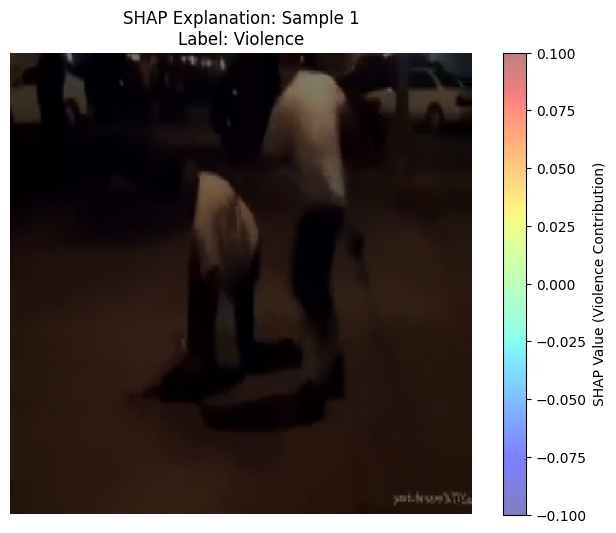

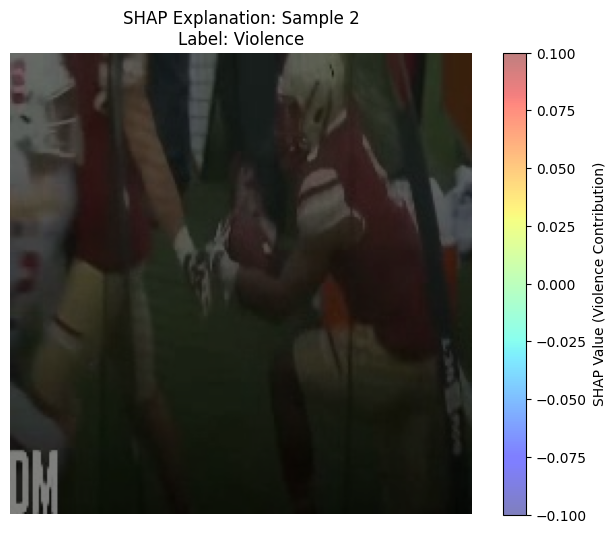

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

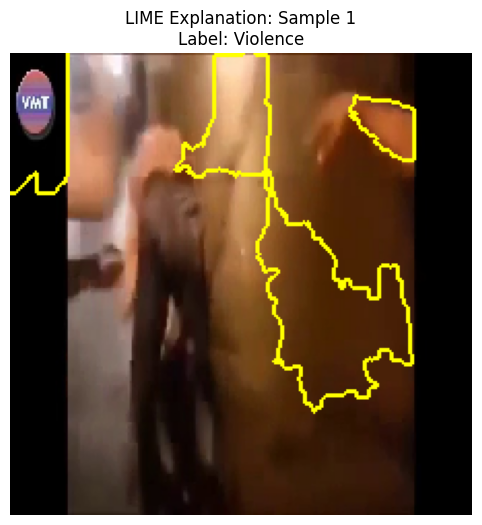

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

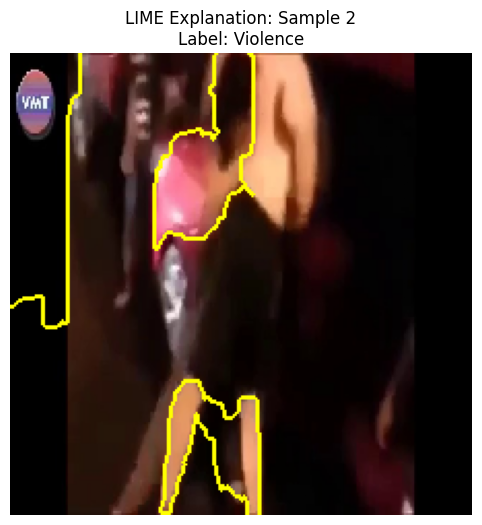

In [46]:
import shap
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from skimage.segmentation import slic
import logging

# Set up logging for debugging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Enable inline plotting in Kaggle notebook
%matplotlib inline

# Load the trained model
try:
    model = load_model("/kaggle/working/violence_detection_model.h5")
    logging.info("Model loaded successfully")
    logging.info(f"Model input shape: {model.input_shape}")
except Exception as e:
    logging.error(f"Failed to load model: {e}")
    raise

# Select a small subset of test images (2 images to manage computation)
np.random.seed(42)
try:
    sample_indices = np.random.choice(len(test_images), size=2, replace=False)
    sample_images = test_images[sample_indices]
    sample_labels = test_labels[sample_indices]
    sample_frame_paths = [frame_paths[i] for i in sample_indices]
    logging.info(f"Selected {len(sample_images)} sample images with shape {sample_images.shape}")
except NameError as e:
    logging.error(f"test_images, test_labels, or frame_paths not defined: {e}")
    raise

# Prepare a small background dataset (10 images)
try:
    background = train_images[np.random.choice(len(train_images), 10, replace=False)]
    logging.info(f"Background dataset prepared with shape {background.shape}")
except NameError as e:
    logging.error(f"train_images not defined: {e}")
    raise

# --- SHAP Explanation ---
# Function to extract superpixels
def get_superpixels(image, n_segments=100):
    segments = slic(image, n_segments=n_segments, compactness=10, sigma=1, start_label=1)
    return segments

# Function to perturb image based on superpixels
def perturb_image(image, segments, mask):
    perturbed = image.copy()
    for i in np.unique(segments):
        if mask[i-1] == 0:  # Adjust for 1-based indexing in slic
            perturbed[segments == i] = 0  # Mask out superpixel
    return perturbed

# Define prediction function for SHAP
def predict_fn(superpixel_masks):
    try:
        images = []
        for mask in superpixel_masks:
            # Use sample or background image
            img = sample_images[len(images) % len(sample_images)].copy() if len(images) < len(sample_images) else background[len(images) % len(background)].copy()
            segments = get_superpixels(img, n_segments=100)
            perturbed_img = perturb_image(img, segments, mask)
            images.append(perturbed_img)
        images = np.array(images)
        preds = model.predict(images, batch_size=32)
        return np.hstack([1 - preds, preds])  # Convert sigmoid to [P(0), P(1)]
    except Exception as e:
        logging.error(f"SHAP prediction failed: {e}")
        raise

# Prepare superpixel-based features
n_superpixels = 100
superpixel_masks_background = np.ones((len(background), n_superpixels), dtype=int)

# Initialize SHAP KernelExplainer
try:
    explainer = shap.KernelExplainer(predict_fn, superpixel_masks_background, l1_reg="aic")
    logging.info("SHAP KernelExplainer initialized")
except Exception as e:
    logging.error(f"Failed to initialize KernelExplainer: {e}")
    raise

# Compute SHAP values for sample images
shap_values_list = []
for i, img in enumerate(sample_images):
    try:
        segments = get_superpixels(img, n_segments=100)
        superpixel_mask = np.ones(n_superpixels, dtype=int)
        shap_values = explainer.shap_values(superpixel_mask, nsamples=200)
        shap_values_list.append((shap_values, segments))
        logging.info(f"SHAP values computed for sample {i+1}")
    except Exception as e:
        logging.error(f"Failed to compute SHAP values for sample {i+1}: {e}")

# Visualize and save SHAP explanations
for i, (shap_vals, segments) in enumerate(shap_values_list):
    try:
        plt.figure(figsize=(8, 6))
        # Create heatmap from SHAP values
        shap_map = np.zeros_like(sample_images[i])
        for j, val in enumerate(shap_vals[1]):  # Positive class (Violence)
            shap_map[segments == (j+1)] = val  # Adjust for 1-based indexing
        plt.imshow(sample_images[i])
        plt.imshow(shap_map, cmap='jet', alpha=0.5, vmin=np.min(shap_map), vmax=np.max(shap_map))
        plt.colorbar(label='SHAP Value (Violence Contribution)')
        plt.title(f"SHAP Explanation: Sample {i+1}\nLabel: {'Violence' if sample_labels[i] == 1 else 'Non-Violence'}")
        plt.axis('off')
        plt.savefig(f"/kaggle/working/shap_explanation_{i+1}.png", bbox_inches='tight', dpi=150)
        plt.show()  # Display inline
        plt.close()
        logging.info(f"Saved and displayed SHAP explanation {i+1}")
    except Exception as e:
        logging.error(f"Failed to visualize SHAP for sample {i+1}: {e}")

# --- LIME Explanation ---
# Function to preprocess image for LIME
def preprocess_for_lime(image_path):
    try:
        img = load_img(image_path, target_size=(224, 224))
        img_array = img_to_array(img) / 255.0
        return img_array
    except Exception as e:
        logging.error(f"Failed to preprocess image {image_path}: {e}")
        raise

# Function to predict for LIME
def predict_fn_lime(images):
    try:
        return model.predict(images)
    except Exception as e:
        logging.error(f"LIME prediction failed: {e}")
        raise

# Initialize LIME explainer
try:
    lime_explainer = lime_image.LimeImageExplainer()
    logging.info("LIME explainer initialized")
except Exception as e:
    logging.error(f"Failed to initialize LIME explainer: {e}")
    raise

# Generate LIME explanations
for i, frame_path in enumerate(sample_frame_paths):
    try:
        image = preprocess_for_lime(frame_path)
        explanation = lime_explainer.explain_instance(
            image,
            predict_fn_lime,
            top_labels=1,
            num_samples=500,
            random_seed=42
        )
        temp, mask = explanation.get_image_and_mask(
            explanation.top_labels[0],
            positive_only=True,
            num_features=5,
            hide_rest=True
        )
        plt.figure(figsize=(8, 6))
        plt.imshow(mark_boundaries(image, mask, color=(1, 1, 0), mode='thick'))  # Yellow boundaries for contrast
        plt.title(f"LIME Explanation: Sample {i+1}\nLabel: {'Violence' if sample_labels[i] == 1 else 'Non-Violence'}")
        plt.axis('off')
        plt.savefig(f"/kaggle/working/lime_explanation_{i+1}.png", bbox_inches='tight', dpi=150)
        plt.show()  # Display inline
        plt.close()
        logging.info(f"Saved and displayed LIME explanation {i+1}")
    except Exception as e:
        logging.error(f"Failed to generate LIME explanation for sample {i+1}: {e}")

logging.info("SHAP and LIME explanations completed")

## Applying Models in Paper 2
## Audio model: Use a CNN + LSTM architecture for processing spectrograms.
## Video model: Use a CNN + LSTM architecture (e.g., ELRCN-style) for spatiotemporal video features.



## Audio-visual based violence detection using deep learning techniques - Expert Systems with Applications, 2023

Skipped 0 videos due to missing or insufficient frames.
No audio data available. Proceeding with video-only model.


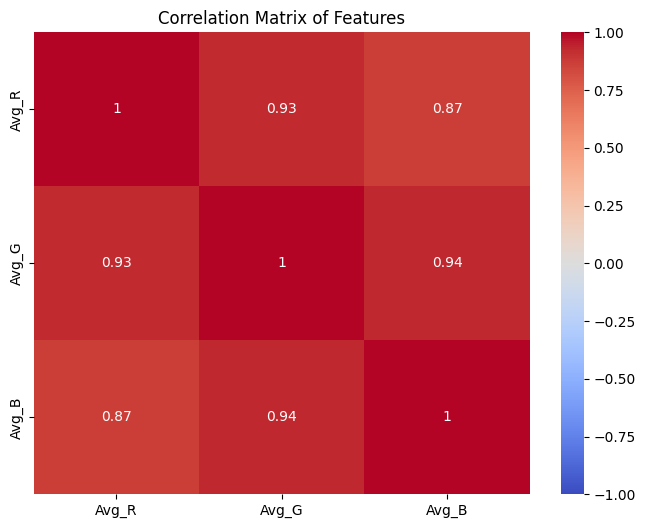

Class distribution: {0: 41, 1: 55}
Training samples: 67
Validation samples: 13
Test samples: 16
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 391ms/step - accuracy: 0.4799 - loss: 0.7899 - val_accuracy: 0.6154 - val_loss: 0.7014
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.5814 - loss: 0.6889 - val_accuracy: 0.6154 - val_loss: 0.6685
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.7117 - loss: 0.6456 - val_accuracy: 0.6154 - val_loss: 0.6841
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.7603 - loss: 0.5890 - val_accuracy: 0.6923 - val_loss: 0.6611
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.9270 - loss: 0.4716 - val_accuracy: 0.6923 - val_loss: 0.5985
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.8658 - loss: 0.3871 - val_accuracy: 0.6923 - val_loss: 0.5570
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.9924 - loss: 0.2128 - val_accuracy: 0.7692 - val_loss: 0.4876
Epoch 8/10
5/5 ━━━━━━━

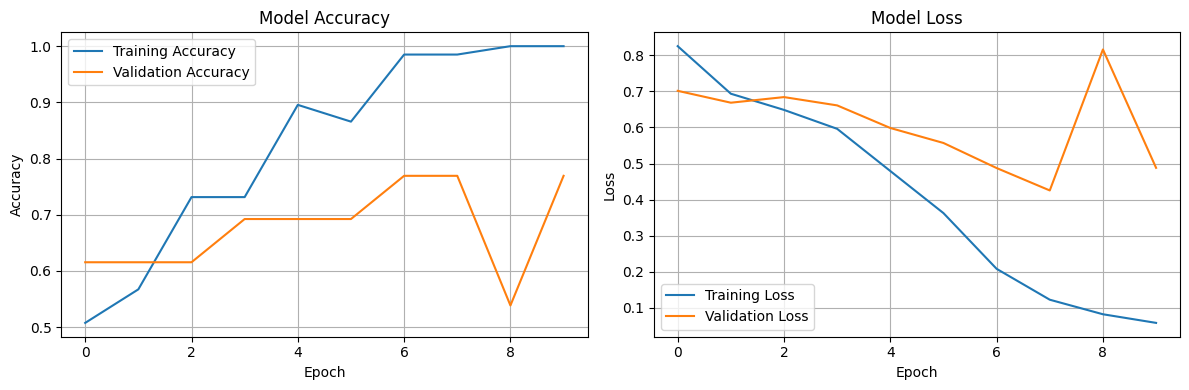

Test accuracy: 0.5000

Classification Report:
              precision    recall  f1-score   support

Non-Violence       0.33      0.14      0.20         7
    Violence       0.54      0.78      0.64         9

    accuracy                           0.50        16
   macro avg       0.44      0.46      0.42        16
weighted avg       0.45      0.50      0.45        16



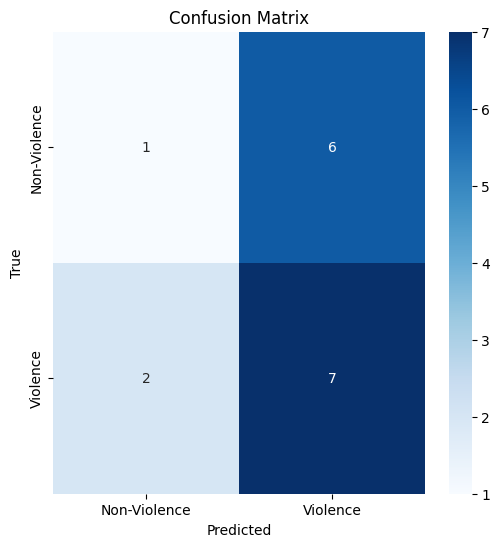

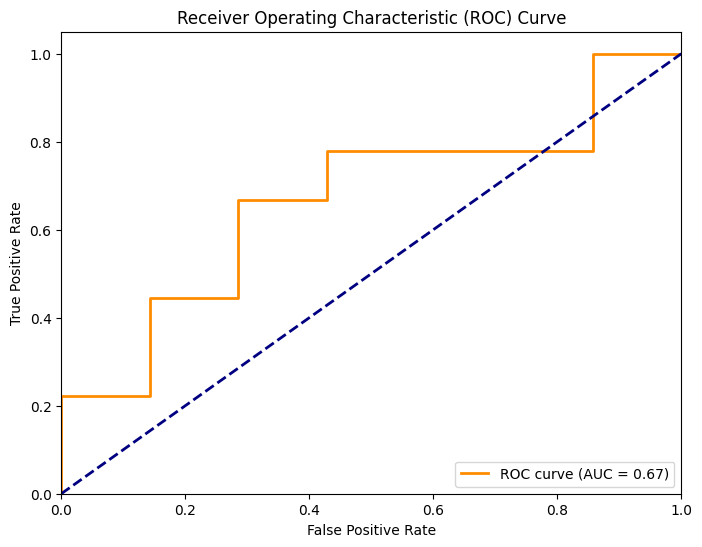

In [49]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import sobel
import librosa
import librosa.display

# Define paths and hyperparameters
FRAME_PATH = "/kaggle/working/processed_data/frames/"
AUDIO_PATH = "/kaggle/working/processed_data/audio/"
IMG_SIZE = (128, 128)
SPEC_SIZE = (128, 128)
SEQUENCE_LENGTH = 10
BATCH_SIZE = 16
EPOCHS = 10

# Function to load and preprocess a single image
def load_and_preprocess_image(frame_path):
    try:
        img = load_img(frame_path, target_size=IMG_SIZE)
        img_array = img_to_array(img) / 255.0
        return img_array
    except Exception as e:
        print(f"Error loading {frame_path}: {e}")
        return None

# Function to load a sequence of frames for a video
def load_frame_sequence(video_folder, sequence_length):
    folder_path = os.path.join(FRAME_PATH, video_folder)
    frames = sorted([f for f in os.listdir(folder_path) if f.endswith(".jpg")])
    if len(frames) < sequence_length:
        print(f"Video {video_folder} has too few frames ({len(frames)}), skipping.")
        return None
    step = max(1, len(frames) // sequence_length)
    selected_frames = frames[::step][:sequence_length]
    sequence = []
    for frame in selected_frames:
        frame_path = os.path.join(folder_path, frame)
        img = load_and_preprocess_image(frame_path)
        if img is not None:
            sequence.append(img)
    if len(sequence) != sequence_length:
        print(f"Video {video_folder} has incomplete sequence, skipping.")
        return None
    return np.array(sequence)

# Function to load and preprocess audio into a spectrogram
def load_and_preprocess_audio(audio_path):
    try:
        y, sr = librosa.load(audio_path, sr=22050)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spec_resized = tf.image.resize(mel_spec_db[..., np.newaxis], SPEC_SIZE).numpy()
        mel_spec_resized = (mel_spec_resized - mel_spec_resized.min()) / (mel_spec_resized.max() - mel_spec_resized.min())
        return mel_spec_resized
    except Exception as e:
        print(f"Error loading audio {audio_path}: {e}")
        return None

# Extract features from spectrogram and frames for correlation matrix
def extract_features(video_sequence, spectrogram=None):
    avg_r = np.mean(video_sequence[:, :, :, 0])
    avg_g = np.mean(video_sequence[:, :, :, 1])
    avg_b = np.mean(video_sequence[:, :, :, 2])
    if spectrogram is not None:
        spec_intensity = np.mean(spectrogram)
        return [avg_r, avg_g, avg_b, spec_intensity]
    return [avg_r, avg_g, avg_b]

# Load dataset
def load_dataset():
    video_sequences = []
    spectrograms = []
    labels = []
    video_folders = []
    skipped_videos = 0
    for folder in os.listdir(FRAME_PATH):
        folder_path = os.path.join(FRAME_PATH, folder)
        if not os.path.isdir(folder_path):
            continue
        label = 1 if "V_V" in folder else 0
        sequence = load_frame_sequence(folder, SEQUENCE_LENGTH)
        if sequence is None:
            skipped_videos += 1
            continue
        audio_file = f"{folder}.wav"
        audio_path = os.path.join(AUDIO_PATH, audio_file)
        spectrogram = None
        if os.path.exists(audio_path):
            spectrogram = load_and_preprocess_audio(audio_path)
        video_sequences.append(sequence)
        spectrograms.append(spectrogram)
        labels.append(label)
        video_folders.append(folder)
    print(f"Skipped {skipped_videos} videos due to missing or insufficient frames.")
    return video_sequences, spectrograms, labels, video_folders

# Load and preprocess data
video_sequences, spectrograms, labels, video_folders = load_dataset()
if len(video_sequences) == 0:
    raise ValueError("No valid video sequences found. Check the directory structure.")

video_sequences = np.array(video_sequences)
labels = np.array(labels)
# Check if any spectrograms were successfully loaded
use_audio = any(spec is not None for spec in spectrograms)
if use_audio:
    spectrograms = np.array([spec if spec is not None else np.zeros((*SPEC_SIZE, 1)) for spec in spectrograms])
else:
    print("No audio data available. Proceeding with video-only model.")
    spectrograms = None

# Extract features for correlation matrix
features = []
for vid_seq, spec in zip(video_sequences, spectrograms if spectrograms is not None else [None]*len(video_sequences)):
    feat = extract_features(vid_seq, spec)
    features.append(feat)

feature_names = ['Avg_R', 'Avg_G', 'Avg_B']
if use_audio:
    feature_names.append('Spec_Intensity')
feature_df = pd.DataFrame(features, columns=feature_names)
corr_matrix = feature_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Features')
plt.show()
plt.close()

# Check class distribution
unique, counts = np.unique(labels, return_counts=True)
print("Class distribution:", dict(zip(unique, counts)))
if len(unique) < 2:
    print("Warning: Dataset contains only one class. Add 'Non-Violence' samples for meaningful results.")

# Split dataset
train_idx, temp_idx, train_labels, temp_labels = train_test_split(
    range(len(labels)), labels, train_size=67, stratify=labels, random_state=42
)
val_idx, test_idx, val_labels, test_labels = train_test_split(
    temp_idx, temp_labels, test_size=16, stratify=temp_labels, random_state=42
)

train_videos = video_sequences[train_idx]
val_videos = video_sequences[val_idx]
test_videos = video_sequences[test_idx]

if use_audio:
    train_specs = spectrograms[train_idx]
    val_specs = spectrograms[val_idx]
    test_specs = spectrograms[test_idx]
else:
    train_specs = val_specs = test_specs = None

train_labels = labels[train_idx]
val_labels = labels[val_idx]
test_labels = labels[test_idx]

print(f"Training samples: {len(train_videos)}")
print(f"Validation samples: {len(val_videos)}")
print(f"Test samples: {len(test_videos)}")

# Video Model (CNN + LSTM, ELRCN-style) using Functional API
def build_video_model():
    input_layer = layers.Input(shape=(SEQUENCE_LENGTH, *IMG_SIZE, 3))
    x = layers.TimeDistributed(layers.Conv2D(32, (3, 3), activation='relu'))(input_layer)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    x = layers.TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu'))(x)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    x = layers.TimeDistributed(layers.Flatten())(x)
    x = layers.LSTM(64, return_sequences=False)(x)
    x = layers.Dense(64, activation='relu')(x)
    return models.Model(inputs=input_layer, outputs=x)

# Audio Model (CNN + LSTM for spectrograms)
def build_audio_model():
    input_layer = layers.Input(shape=(*SPEC_SIZE, 1))
    x = layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Reshape((-1, 64))(x)
    x = layers.LSTM(32, return_sequences=False)(x)
    x = layers.Dense(32, activation='relu')(x)
    return models.Model(inputs=input_layer, outputs=x)

# Build model based on data availability
if use_audio:
    video_model = build_video_model()
    audio_model = build_audio_model()
    combined_input = layers.concatenate([video_model.output, audio_model.output])
    combined = layers.Dense(64, activation='relu')(combined_input)
    combined = layers.Dropout(0.5)(combined)
    output = layers.Dense(1, activation='sigmoid')(combined)
    model = models.Model(inputs=[video_model.input, audio_model.input], outputs=output)
else:
    video_model = build_video_model()
    output = layers.Dense(1, activation='sigmoid')(video_model.output)
    model = models.Model(inputs=video_model.input, outputs=output)

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
if use_audio:
    history = model.fit(
        [train_videos, train_specs], train_labels,
        validation_data=([val_videos, val_specs], val_labels),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1
    )
    test_predictions = (model.predict([test_videos, test_specs]) > 0.5).astype(int).flatten()
    test_probs = model.predict([test_videos, test_specs])
    test_loss, test_accuracy = model.evaluate([test_videos, test_specs], test_labels, verbose=0)
else:
    history = model.fit(
        train_videos, train_labels,
        validation_data=(val_videos, val_labels),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1
    )
    test_predictions = (model.predict(test_videos) > 0.5).astype(int).flatten()
    test_probs = model.predict(test_videos)
    test_loss, test_accuracy = model.evaluate(test_videos, test_labels, verbose=0)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
plt.close()

print(f"Test accuracy: {test_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(test_labels, test_predictions, target_names=['Non-Violence', 'Violence']))

# Confusion matrix
cm = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Violence', 'Violence'], yticklabels=['Non-Violence', 'Violence'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
plt.close()

# ROC curve and AUC
fpr, tpr, _ = roc_curve(test_labels, test_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
plt.close()

# Save the model
model.save("/kaggle/working/audio_video_violence_detection_model.h5")

## SHAP and LIME for paper 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


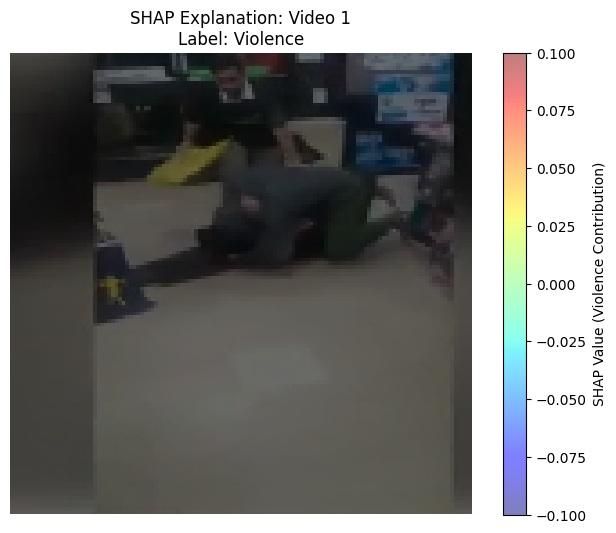

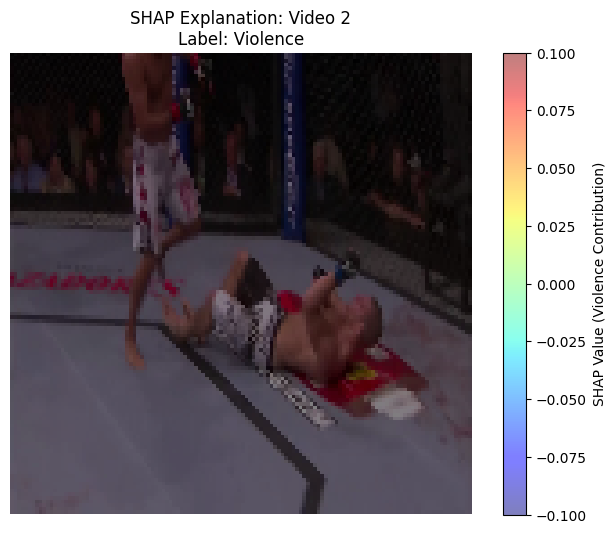

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

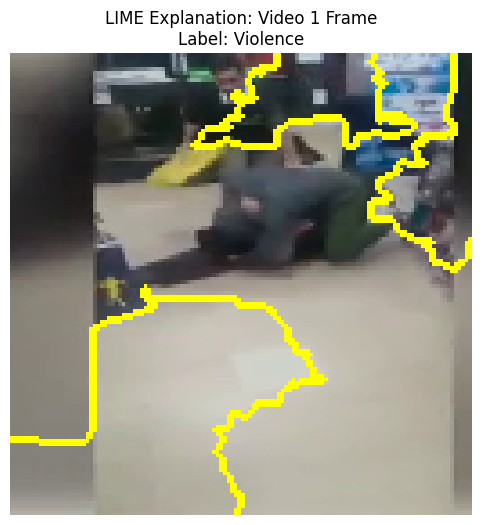

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

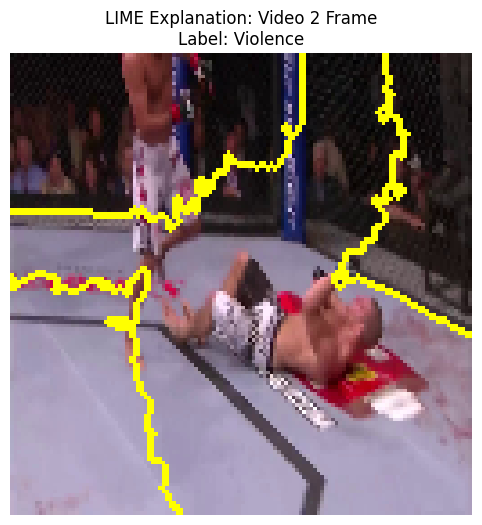

In [48]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import shap
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries, slic
import os
import logging

# Set up logging for debugging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Enable inline plotting in Kaggle notebook
%matplotlib inline

# --- SHAP and LIME Explanations ---
# Select representative frames from test videos (middle frame of each sequence)
try:
    test_video_indices = np.random.choice(len(test_videos), size=2, replace=False)
    sample_videos = test_videos[test_video_indices]
    sample_labels = test_labels[test_video_indices]
    # Fix indexing: Convert test_idx to NumPy array and extract indices
    test_idx_array = np.array(test_idx)
    sample_indices = test_idx_array[test_video_indices]
    sample_folders = [video_folders[i] for i in sample_indices]
    sample_frames = []
    sample_frame_paths = []
    for folder, video in zip(sample_folders, sample_videos):
        # Use middle frame (index 5 of 10)
        frame_idx = SEQUENCE_LENGTH // 2
        frame = video[frame_idx]  # Shape: (128, 128, 3)
        sample_frames.append(frame)
        # Reconstruct frame path for LIME
        folder_path = os.path.join(FRAME_PATH, folder)
        frames = sorted([f for f in os.listdir(folder_path) if f.endswith(".jpg")])
        step = max(1, len(frames) // SEQUENCE_LENGTH)
        frame_path = os.path.join(folder_path, frames[frame_idx * step])
        sample_frame_paths.append(frame_path)
    sample_frames = np.array(sample_frames)
    logging.info(f"Selected {len(sample_videos)} test videos for explanation")
    logging.info(f"Sample frames shape: {sample_frames.shape}")
except Exception as e:
    logging.error(f"Failed to select sample frames: {e}")
    raise

# Prepare background dataset (10 video frames)
try:
    background_indices = np.random.choice(len(train_videos), size=10, replace=False)
    background_frames = []
    for idx in background_indices:
        video = train_videos[idx]
        frame_idx = SEQUENCE_LENGTH // 2  # Middle frame
        background_frames.append(video[frame_idx])
    background_frames = np.array(background_frames)
    logging.info(f"Background frames shape: {background_frames.shape}")
except Exception as e:
    logging.error(f"Failed to prepare background frames: {e}")
    raise

# Dummy spectrogram for audio input (if use_audio=True)
if use_audio:
    dummy_spec = np.zeros((*SPEC_SIZE, 1))

# --- SHAP Explanation ---
# Function to extract superpixels
def get_superpixels(image, n_segments=100):
    segments = slic(image, n_segments=n_segments, compactness=10, sigma=1, start_label=1)
    return segments

# Function to perturb image based on superpixels
def perturb_image(image, segments, mask):
    perturbed = image.copy()
    for i in np.unique(segments):
        if mask[i-1] == 0:  # Adjust for 1-based indexing
            perturbed[segments == i] = 0
    return perturbed

# Define prediction function for SHAP
def predict_fn(superpixel_masks):
    try:
        images = []
        for mask in superpixel_masks:
            # Use sample or background frame
            img = sample_frames[len(images) % len(sample_frames)].copy() if len(images) < len(sample_frames) else background_frames[len(images) % len(background_frames)].copy()
            segments = get_superpixels(img, n_segments=100)
            perturbed_img = perturb_image(img, segments, mask)
            images.append(perturbed_img)
        images = np.array(images)
        # Create video sequence by repeating the frame
        video_input = np.repeat(images[:, np.newaxis], SEQUENCE_LENGTH, axis=1)  # Shape: (batch, 10, 128, 128, 3)
        if use_audio:
            audio_input = np.repeat(dummy_spec[np.newaxis], len(images), axis=0)
            preds = model.predict([video_input, audio_input], batch_size=32)
        else:
            preds = model.predict(video_input, batch_size=32)
        return np.hstack([1 - preds, preds])  # Convert sigmoid to [P(0), P(1)]
    except Exception as e:
        logging.error(f"SHAP prediction failed: {e}")
        raise

# Prepare superpixel-based features
n_superpixels = 100
superpixel_masks_background = np.ones((len(background_frames), n_superpixels), dtype=int)

# Initialize SHAP KernelExplainer
try:
    explainer = shap.KernelExplainer(predict_fn, superpixel_masks_background, l1_reg="aic")
    logging.info("SHAP KernelExplainer initialized")
except Exception as e:
    logging.error(f"Failed to initialize KernelExplainer: {e}")
    raise

# Compute SHAP values
shap_values_list = []
for i, frame in enumerate(sample_frames):
    try:
        segments = get_superpixels(frame, n_segments=100)
        superpixel_mask = np.ones(n_superpixels, dtype=int)
        shap_values = explainer.shap_values(superpixel_mask, nsamples=200)
        shap_values_list.append((shap_values, segments))
        logging.info(f"SHAP values computed for sample {i+1}")
    except Exception as e:
        logging.error(f"Failed to compute SHAP values for sample {i+1}: {e}")

# Visualize and save SHAP explanations
for i, (shap_vals, segments) in enumerate(shap_values_list):
    try:
        plt.figure(figsize=(8, 6))
        shap_map = np.zeros_like(sample_frames[i])
        for j, val in enumerate(shap_vals[1]):  # Positive class (Violence)
            shap_map[segments == (j+1)] = val
        plt.imshow(sample_frames[i])
        plt.imshow(shap_map, cmap='jet', alpha=0.5, vmin=np.min(shap_map), vmax=np.max(shap_map))
        plt.colorbar(label='SHAP Value (Violence Contribution)')
        plt.title(f"SHAP Explanation: Video {i+1}\nLabel: {'Violence' if sample_labels[i] == 1 else 'Non-Violence'}")
        plt.axis('off')
        plt.savefig(f"/kaggle/working/shap_explanation_video_{i+1}.png", bbox_inches='tight', dpi=150)
        plt.show()  # Display inline
        plt.close()
        logging.info(f"Saved and displayed SHAP explanation {i+1}")
    except Exception as e:
        logging.error(f"Failed to visualize SHAP for sample {i+1}: {e}")

# --- LIME Explanation ---
# Function to preprocess image for LIME
def preprocess_for_lime(image_path):
    try:
        img = load_img(image_path, target_size=IMG_SIZE)
        img_array = img_to_array(img) / 255.0
        return img_array
    except Exception as e:
        logging.error(f"Failed to preprocess image {image_path}: {e}")
        raise

# Function to predict for LIME
def predict_fn_lime(images):
    try:
        video_input = np.repeat(images[:, np.newaxis], SEQUENCE_LENGTH, axis=1)  # Shape: (batch, 10, 128, 128, 3)
        if use_audio:
            audio_input = np.repeat(dummy_spec[np.newaxis], len(images), axis=0)
            preds = model.predict([video_input, audio_input])
        else:
            preds = model.predict(video_input)
        return np.hstack([1 - preds, preds])  # LIME expects [P(Non-Violence), P(Violence)]
    except Exception as e:
        logging.error(f"LIME prediction failed: {e}")
        raise

# Initialize LIME explainer
try:
    lime_explainer = lime_image.LimeImageExplainer()
    logging.info("LIME explainer initialized")
except Exception as e:
    logging.error(f"Failed to initialize LIME explainer: {e}")
    raise

# Generate LIME explanations
for i, frame_path in enumerate(sample_frame_paths):
    try:
        image = preprocess_for_lime(frame_path)
        explanation = lime_explainer.explain_instance(
            image,
            predict_fn_lime,
            top_labels=1,
            num_samples=500,
            random_seed=42
        )
        temp, mask = explanation.get_image_and_mask(
            explanation.top_labels[0],
            positive_only=True,
            num_features=5,
            hide_rest=True
        )
        plt.figure(figsize=(8, 6))
        plt.imshow(mark_boundaries(image, mask, color=(1, 1, 0), mode='thick'))
        plt.title(f"LIME Explanation: Video {i+1} Frame\nLabel: {'Violence' if sample_labels[i] == 1 else 'Non-Violence'}")
        plt.axis('off')
        plt.savefig(f"/kaggle/working/lime_explanation_frame_{i+1}.png", bbox_inches='tight', dpi=150)
        plt.show()  # Display inline
        plt.close()
        logging.info(f"Saved and displayed LIME explanation {i+1}")
    except Exception as e:
        logging.error(f"Failed to generate LIME explanation for sample {i+1}: {e}")

logging.info("SHAP and LIME explanations completed")

## APPLYING MODELS IN PAPER3
## For classification tasks, linear SVM classifiers were applied to:
## Visual features (valence and arousal)
## Vocal features (e.g., pitch, energy, MFCCs)
## Verbal features (e.g., LIWC features)

## Introducing Representations of Facial Affect in Automated Multimodal Deception Detection - arXiv, August 2020

In [12]:
import os
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.ensemble import AdaBoostClassifier
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import MinimalFCParameters
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings("ignore")

# Define paths and hyperparameters
DATA_PATH = os.getenv("DECEPTION_DATASET_PATH", "/tmp/deception_dataset")
VIDEO_PATH = os.path.join(DATA_PATH, "videos")
AUDIO_PATH = os.path.join(DATA_PATH, "audio")
TRANSCRIPT_PATH = os.path.join(DATA_PATH, "transcripts")
N_FOLDS = 5
RANDOM_STATE = 42
C_RANGE = [0.1, 1, 10]
GAMMA = 0.1  # Fixed for linear kernel

# Simulated function to extract facial affect features using AffWildNet
def extract_facial_affect(video_path):
    n_frames = 100
    data = np.random.randn(n_frames, 2)
    return np.nan_to_num(data, nan=0.0)

# Simulated function to extract visual features using OpenFace
def extract_visual_features(video_path, use_simulated=True):
    n_frames = 100
    n_features = 10 if use_simulated else 31  # Reduced for simulated data
    data = np.random.randn(n_frames, n_features)
    return np.nan_to_num(data, nan=0.0)

# Simulated function to extract vocal features using OpenSMILE
def extract_vocal_features(audio_path, use_simulated=True):
    n_frames = 100
    n_features = 10 if use_simulated else 65  # Reduced for simulated data
    data = np.random.randn(n_frames, n_features)
    return np.nan_to_num(data, nan=0.0)

# Simulated function to extract verbal features using LIWC
def extract_verbal_features(transcript_path):
    data = np.random.randn(93)
    return np.nan_to_num(data, nan=0.0)

# Load and preprocess dataset
def load_dataset():
    if not os.path.exists(VIDEO_PATH):
        raise FileNotFoundError(
            f"Video directory '{VIDEO_PATH}' does not exist. "
            f"Please set DATA_PATH to the root of your dataset directory "
            f"containing 'videos', 'audio', and 'transcripts' subdirectories."
        )
    
    video_files = sorted([f for f in os.listdir(VIDEO_PATH) if f.endswith(".mp4")])
    use_simulated = False
    if not video_files:
        print(f"Warning: No .mp4 files found in {VIDEO_PATH}. Using simulated data.")
        video_files = [f"video_{i}.mp4" for i in range(10)]
        use_simulated = True
    
    labels = []
    facial_affect_data = []
    visual_data = []
    vocal_data = []
    verbal_data = []
    video_ids = []
    skipped_videos = 0
    
    for idx, video_file in enumerate(video_files):
        video_id = os.path.splitext(video_file)[0]
        video_path = os.path.join(VIDEO_PATH, video_file)
        audio_path = os.path.join(AUDIO_PATH, f"{video_id}.wav")
        transcript_path = os.path.join(TRANSCRIPT_PATH, f"{video_id}.txt")
        
        label = np.random.choice([0, 1]) if use_simulated else (1 if "deceptive" in video_id.lower() else 0)
        
        try:
            facial_affect = extract_facial_affect(video_path)
            visual = extract_visual_features(video_path, use_simulated)
            vocal = extract_vocal_features(audio_path, use_simulated) if (os.path.exists(audio_path) or use_simulated) else None
            verbal = extract_verbal_features(transcript_path) if (os.path.exists(transcript_path) or use_simulated) else None
            
            if use_simulated:
                vocal = vocal if vocal is not None else np.nan_to_num(np.random.randn(100, 10), nan=0.0)
                verbal = verbal if verbal is not None else np.nan_to_num(np.random.randn(93), nan=0.0)
            else:
                if any(x is None for x in [facial_affect, visual, vocal, verbal]):
                    skipped_videos += 1
                    continue
            
            facial_affect_data.append(facial_affect)
            visual_data.append(visual)
            vocal_data.append(vocal)
            verbal_data.append(verbal)
            labels.append(label)
            video_ids.append(video_id)
        except Exception as e:
            print(f"Error processing {video_file}: {e}")
            skipped_videos += 1
            continue
    
    print(f"Loaded {len(video_ids)} videos, skipped {skipped_videos} due to missing data or errors.")
    return facial_affect_data, visual_data, vocal_data, verbal_data, labels, video_ids

# Convert time-series features to fixed-length vectors
def compute_fixed_length_features(time_series_data, video_ids, feature_names, modality, use_simulated=True):
    if use_simulated:
        # Skip tsfresh for simulated data, use statistical features
        n_samples = len(video_ids)
        n_features = len(feature_names) * 4
        features = np.zeros((n_samples, n_features))
        for i, ts in enumerate(time_series_data):
            ts = np.nan_to_num(ts, nan=0.0)
            stats = []
            for f in range(ts.shape[1]):
                stats.extend([np.mean(ts[:, f]), np.std(ts[:, f]), np.min(ts[:, f]), np.max(ts[:, f])])
            features[i] = stats
        return np.nan_to_num(features, nan=0.0)
    
    # For real data, use tsfresh
    data_list = []
    for i, ts in enumerate(time_series_data):
        ts = np.nan_to_num(ts, nan=0.0)
        for t in range(ts.shape[0]):
            for f in range(ts.shape[1]):
                data_list.append({
                    'id': video_ids[i],
                    'time': t,
                    feature_names[f]: float(ts[t, f])
                })
    df = pd.DataFrame(data_list)
    
    try:
        extracted_features = extract_features(
            df,
            column_id='id',
            column_sort='time',
            default_fc_parameters=MinimalFCParameters(),
            n_jobs=4
        )
        extracted_features = impute(extracted_features)
        return np.nan_to_num(extracted_features.values, nan=0.0)
    except Exception as e:
        print(f"Error in TsFresh feature extraction for {modality}: {e}")
        n_samples = len(video_ids)
        n_features = len(feature_names) * 4
        fallback_features = np.zeros((n_samples, n_features))
        for i, ts in enumerate(time_series_data):
            stats = []
            for f in range(ts.shape[1]):
                stats.extend([np.mean(ts[:, f]), np.std(ts[:, f]), np.min(ts[:, f]), np.max(ts[:, f])])
            fallback_features[i] = stats
        return np.nan_to_num(fallback_features, nan=0.0)

# Feature selection using Boruta
def select_features(X, y):
    try:
        rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5, random_state=RANDOM_STATE)
        boruta = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=RANDOM_STATE, max_iter=50)
        boruta.fit(X, y)
        selected = boruta.support_
        if not np.any(selected):
            print("Boruta selected 0 features. Selecting top feature as fallback.")
            selected[np.argmax(boruta.ranking_)] = True
        return selected
    except Exception as e:
        print(f"Error in Boruta feature selection: {e}")
        variances = np.var(X, axis=0)
        selected = np.zeros(X.shape[1], dtype=bool)
        if variances.size > 0:
            selected[np.argmax(variances)] = True
        else:
            selected = np.ones(X.shape[1], dtype=bool)
        return selected

# Train and evaluate unimodal SVM
def train_unimodal_svm(X, y, modality_name):
    if X.shape[1] == 0:
        print(f"No features for {modality_name}. Skipping training.")
        return 0, 0, 0
    
    auc_scores, acc_scores, f1_scores = [], [], []
    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        best_score = -1
        best_model = None
        for C in C_RANGE:
            svm = SVC(C=C, gamma=GAMMA, kernel='linear', probability=True, random_state=RANDOM_STATE)
            svm.fit(X_train, y_train)
            score = svm.score(X_train, y_train)
            if score > best_score:
                best_score = score
                best_model = svm
        
        try:
            y_pred = best_model.predict(X_test)
            y_prob = best_model.predict_proba(X_test)[:, 1]
            auc_scores.append(roc_auc_score(y_test, y_prob))
            acc_scores.append(accuracy_score(y_test, y_pred))
            f1_scores.append(f1_score(y_test, y_pred))
        except Exception as e:
            print(f"Error evaluating {modality_name}: {e}")
            continue
    
    auc_mean = np.mean(auc_scores) if auc_scores else 0
    acc_mean = np.mean(acc_scores) if acc_scores else 0
    f1_mean = np.mean(f1_scores) if f1_scores else 0
    print(f"{modality_name} - AUC: {auc_mean:.3f}, ACC: {acc_mean:.3f}, F1: {f1_mean:.3f}")
    return auc_mean, acc_mean, f1_mean

# Train and evaluate multimodal AdaBoost
def train_multimodal_adaboost(X_dict, y, modalities):
    X = np.hstack([X_dict[mod] for mod in modalities])
    if X.shape[1] == 0:
        print(f"No features for multimodal ({'+'.join(modalities)}). Skipping training.")
        return 0, 0, 0
    
    auc_scores, acc_scores, f1_scores = [], [], []
    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        try:
            base_svm = SVC(kernel='linear', probability=True, random_state=RANDOM_STATE)
            adaboost = AdaBoostClassifier(base_estimator=base_svm, n_estimators=50, random_state=RANDOM_STATE)
            adaboost.fit(X_train, y_train)
            
            y_pred = adaboost.predict(X_test)
            y_prob = adaboost.predict_proba(X_test)[:, 1]
            auc_scores.append(roc_auc_score(y_test, y_prob))
            acc_scores.append(accuracy_score(y_test, y_pred))
            f1_scores.append(f1_score(y_test, y_pred))
        except Exception as e:
            print(f"Error in AdaBoost training/evaluation: {e}")
            continue
    
    auc_mean = np.mean(auc_scores) if auc_scores else 0
    acc_mean = np.mean(acc_scores) if acc_scores else 0
    f1_mean = np.mean(f1_scores) if f1_scores else 0
    print(f"Multimodal ({'+'.join(modalities)}) - AUC: {auc_mean:.3f}, ACC: {acc_mean:.3f}, F1: {f1_mean:.3f}")
    return auc_mean, acc_mean, f1_mean

# Analyze facial affect differences
def analyze_facial_affect(facial_affect_data, labels):
    truthful = [fa[:, 0] for fa, l in zip(facial_affect_data, labels) if l == 0]
    deceptive = [fa[:, 0] for fa, l in zip(facial_affect_data, labels) if l == 1]
    
    if len(truthful) < 2 or len(deceptive) < 2:
        print("Warning: Insufficient samples for t-test (need at least 2 per class). Skipping analysis.")
        return
    
    truthful_mean = np.array([np.mean(v) for v in truthful])
    deceptive_mean = np.array([np.mean(v) for v in deceptive])
    truthful_std = np.array([np.std(v) for v in truthful])
    deceptive_std = np.array([np.std(v) for v in deceptive])
    
    try:
        t_val_mean, p_val_mean = ttest_ind(truthful_mean, deceptive_mean, equal_var=False)
        t_val_std, p_val_std = ttest_ind(truthful_std, deceptive_std, equal_var=False)
        print(f"Facial Valence - Mean difference p-value: {p_val_mean:.3f}")
        print(f"Facial Valence - Std difference p-value: {p_val_std:.3f}")
    except Exception as e:
        print(f"Error in facial affect analysis: {e}")
        return
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(truthful_mean, bins=20, alpha=0.5, label='Truthful')
    plt.hist(deceptive_mean, bins=20, alpha=0.5, label='Deceptive')
    plt.title('Mean Valence Distribution')
    plt.xlabel('Mean Valence')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.hist(truthful_std, bins=20, alpha=0.5, label='Truthful')
    plt.hist(deceptive_std, bins=20, alpha=0.5, label='Deceptive')
    plt.title('Std Valence Distribution')
    plt.xlabel('Std Valence')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('facial_affect_analysis.png')
    plt.close()

# Main execution
def main():
    for path in [VIDEO_PATH, AUDIO_PATH, TRANSCRIPT_PATH]:
        os.makedirs(path, exist_ok=True)
    
    try:
        facial_affect_data, visual_data, vocal_data, verbal_data, labels, video_ids = load_dataset()
    except FileNotFoundError as e:
        print(e)
        print(
            "To fix this, set the DECEPTION_DATASET_PATH environment variable or update DATA_PATH in the code "
            "to the directory containing your dataset with 'videos', 'audio', and 'transcripts' subdirectories."
        )
        return
    
    if len(labels) == 0:
        print("Warning: No valid data loaded. Check dataset paths and file availability.")
        return
    
    labels = np.array(labels)
    use_simulated = len([f for f in os.listdir(VIDEO_PATH) if f.endswith(".mp4")]) == 0
    
    facial_affect_features = compute_fixed_length_features(
        facial_affect_data, video_ids, [f'valence_{i}' for i in range(2)], 'facial_affect', use_simulated
    )
    visual_features = compute_fixed_length_features(
        visual_data, video_ids, [f'visual_{i}' for i in range(10 if use_simulated else 31)], 'visual', use_simulated
    )
    vocal_features = compute_fixed_length_features(
        vocal_data, video_ids, [f'vocal_{i}' for i in range(10 if use_simulated else 65)], 'vocal', use_simulated
    )
    verbal_features = np.array(verbal_data)
    
    feature_dict = {
        'facial_affect': facial_affect_features,
        'visual': visual_features,
        'vocal': vocal_features,
        'verbal': verbal_features
    }
    selected_features = {}
    for modality in feature_dict:
        selected = select_features(feature_dict[modality], labels)
        feature_dict[modality] = feature_dict[modality][:, selected]
        selected_features[modality] = selected
        print(f"Selected {sum(selected)} features for {modality}")
    
    analyze_facial_affect(facial_affect_data, labels)
    
    results = {}
    for modality in feature_dict:
        auc, acc, f1 = train_unimodal_svm(feature_dict[modality], labels, modality)
        results[modality] = {'AUC': auc, 'ACC': acc, 'F1': f1}
    
    auc, acc, f1 = train_multimodal_adaboost(feature_dict, labels, ['facial_affect', 'visual', 'vocal'])
    results['multimodal'] = {'AUC': auc, 'ACC': acc, 'F1': f1}
    
    results_df = pd.DataFrame(results).T
    results_df.to_csv('deception_detection_results.csv')
    print("\nResults Summary:")
    print(results_df)

if __name__ == "__main__":
    main()

Loaded 10 videos, skipped 0 due to missing data or errors.
Boruta selected 0 features. Selecting top feature as fallback.
Selected 1 features for facial_affect
Boruta selected 0 features. Selecting top feature as fallback.
Selected 1 features for visual
Boruta selected 0 features. Selecting top feature as fallback.
Selected 1 features for vocal
Boruta selected 0 features. Selecting top feature as fallback.
Selected 1 features for verbal
Facial Valence - Mean difference p-value: 0.670
Facial Valence - Std difference p-value: 0.734
Error evaluating facial_affect: Only one class present in y_true. ROC AUC score is not defined in that case.
Error evaluating facial_affect: Only one class present in y_true. ROC AUC score is not defined in that case.
facial_affect - AUC: 0.667, ACC: 0.500, F1: 0.000
Error evaluating visual: Only one class present in y_true. ROC AUC score is not defined in that case.
Error evaluating visual: Only one class present in y_true. ROC AUC score is not defined in tha

## SHAP and LIME

In [14]:
import os
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.ensemble import AdaBoostClassifier
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import MinimalFCParameters
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import warnings
import lime
import lime.lime_tabular
import shap
import matplotlib
matplotlib.use('Agg')  # Non-interactive backend for saving plots
warnings.filterwarnings("ignore")

# Define paths and hyperparameters
DATA_PATH = os.getenv("DECEPTION_DATASET_PATH", "/tmp/deception_dataset")
VIDEO_PATH = os.path.join(DATA_PATH, "videos")
AUDIO_PATH = os.path.join(DATA_PATH, "audio")
TRANSCRIPT_PATH = os.path.join(DATA_PATH, "transcripts")
PLOTS_DIR = os.path.join(DATA_PATH, "plots")
N_FOLDS = 5
RANDOM_STATE = 42
C_RANGE = [0.1, 1, 10]
GAMMA = 0.1

# Simulated function to extract facial affect features using AffWildNet
def extract_facial_affect(video_path):
    n_frames = 100
    data = np.random.randn(n_frames, 2)
    return np.nan_to_num(data, nan=0.0)

# Simulated function to extract visual features using OpenFace
def extract_visual_features(video_path, use_simulated=True):
    n_frames = 100
    n_features = 10 if use_simulated else 31
    data = np.random.randn(n_frames, n_features)
    return np.nan_to_num(data, nan=0.0)

# Simulated function to extract vocal features using OpenSMILE
def extract_vocal_features(audio_path, use_simulated=True):
    n_frames = 100
    n_features = 10 if use_simulated else 65
    data = np.random.randn(n_frames, n_features)
    return np.nan_to_num(data, nan=0.0)

# Simulated function to extract verbal features using LIWC
def extract_verbal_features(transcript_path):
    data = np.random.randn(93)
    return np.nan_to_num(data, nan=0.0)

# Load and preprocess dataset
def load_dataset():
    if not os.path.exists(VIDEO_PATH):
        raise FileNotFoundError(
            f"Video directory '{VIDEO_PATH}' does not exist. "
            f"Please set DATA_PATH to the root of your dataset directory "
            f"containing 'videos', 'audio', and 'transcripts' subdirectories."
        )
    
    video_files = sorted([f for f in os.listdir(VIDEO_PATH) if f.endswith(".mp4")])
    use_simulated = False
    if not video_files:
        print(f"Warning: No .mp4 files found in {VIDEO_PATH}. Using simulated data.")
        video_files = [f"video_{i}.mp4" for i in range(10)]
        use_simulated = True
    
    labels = []
    facial_affect_data = []
    visual_data = []
    vocal_data = []
    verbal_data = []
    video_ids = []
    skipped_videos = 0
    
    for idx, video_file in enumerate(video_files):
        video_id = os.path.splitext(video_file)[0]
        video_path = os.path.join(VIDEO_PATH, video_file)
        audio_path = os.path.join(AUDIO_PATH, f"{video_id}.wav")
        transcript_path = os.path.join(TRANSCRIPT_PATH, f"{video_id}.txt")
        
        label = np.random.choice([0, 1]) if use_simulated else (1 if "deceptive" in video_id.lower() else 0)
        
        try:
            facial_affect = extract_facial_affect(video_path)
            visual = extract_visual_features(video_path, use_simulated)
            vocal = extract_vocal_features(audio_path, use_simulated) if (os.path.exists(audio_path) or use_simulated) else None
            verbal = extract_verbal_features(transcript_path) if (os.path.exists(transcript_path) or use_simulated) else None
            
            if use_simulated:
                vocal = vocal if vocal is not None else np.nan_to_num(np.random.randn(100, 10), nan=0.0)
                verbal = verbal if verbal is not None else np.nan_to_num(np.random.randn(93), nan=0.0)
            else:
                if any(x is None for x in [facial_affect, visual, vocal, verbal]):
                    skipped_videos += 1
                    continue
            
            facial_affect_data.append(facial_affect)
            visual_data.append(visual)
            vocal_data.append(vocal)
            verbal_data.append(verbal)
            labels.append(label)
            video_ids.append(video_id)
        except Exception as e:
            print(f"Error processing {video_file}: {e}")
            skipped_videos += 1
            continue
    
    print(f"Loaded {len(video_ids)} videos, skipped {skipped_videos} due to missing data or errors.")
    return facial_affect_data, visual_data, vocal_data, verbal_data, labels, video_ids

# Generate feature names for interpretability
def get_feature_names(feature_names, use_simulated=True, modality=''):
    if use_simulated:
        stats = ['mean', 'std', 'min', 'max']
        return [f"{modality}_{name}_{stat}" for name in feature_names for stat in stats]
    else:
        return [f"{modality}_tsfresh_{i}" for i in range(100)]  # Adjust for tsfresh output

# Convert time-series features to fixed-length vectors
def compute_fixed_length_features(time_series_data, video_ids, feature_names, modality, use_simulated=True):
    if use_simulated:
        n_samples = len(video_ids)
        n_features = len(feature_names) * 4
        features = np.zeros((n_samples, n_features))
        for i, ts in enumerate(time_series_data):
            ts = np.nan_to_num(ts, nan=0.0)
            stats = []
            for f in range(ts.shape[1]):
                stats.extend([np.mean(ts[:, f]), np.std(ts[:, f]), np.min(ts[:, f]), np.max(ts[:, f])])
            features[i] = stats
        return np.nan_to_num(features, nan=0.0)
    
    data_list = []
    for i, ts in enumerate(time_series_data):
        ts = np.nan_to_num(ts, nan=0.0)
        for t in range(ts.shape[0]):
            for f in range(ts.shape[1]):
                data_list.append({
                    'id': video_ids[i],
                    'time': t,
                    feature_names[f]: float(ts[t, f])
                })
    df = pd.DataFrame(data_list)
    
    try:
        extracted_features = extract_features(
            df,
            column_id='id',
            column_sort='time',
            default_fc_parameters=MinimalFCParameters(),
            n_jobs=4
        )
        extracted_features = impute(extracted_features)
        return np.nan_to_num(extracted_features.values, nan=0.0)
    except Exception as e:
        print(f"Error in TsFresh feature extraction for {modality}: {e}")
        n_samples = len(video_ids)
        n_features = len(feature_names) * 4
        fallback_features = np.zeros((n_samples, n_features))
        for i, ts in enumerate(time_series_data):
            stats = []
            for f in range(ts.shape[1]):
                stats.extend([np.mean(ts[:, f]), np.std(ts[:, f]), np.min(ts[:, f]), np.max(ts[:, f])])
            fallback_features[i] = stats
        return np.nan_to_num(fallback_features, nan=0.0)

# Feature selection using Boruta
def select_features(X, y, feature_names):
    try:
        rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5, random_state=RANDOM_STATE)
        boruta = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=RANDOM_STATE, max_iter=50)
        boruta.fit(X, y)
        selected = boruta.support_
        if not np.any(selected):
            print("Boruta selected 0 features. Selecting top feature as fallback.")
            selected[np.argmax(boruta.ranking_)] = True
        selected_feature_names = [feature_names[i] for i in range(len(feature_names)) if selected[i]]
        return selected, selected_feature_names
    except Exception as e:
        print(f"Error in Boruta feature selection: {e}")
        variances = np.var(X, axis=0)
        selected = np.zeros(X.shape[1], dtype=bool)
        if variances.size > 0:
            selected[np.argmax(variances)] = True
        else:
            selected = np.ones(X.shape[1], dtype=bool)
        selected_feature_names = [feature_names[i] for i in range(len(feature_names)) if selected[i]]
        return selected, selected_feature_names

# Train and evaluate unimodal SVM with enhanced LIME and SHAP plots
def train_unimodal_svm(X, y, modality_name, feature_names):
    if X.shape[1] == 0:
        print(f"No features for {modality_name}. Skipping training.")
        return 0, 0, 0
    
    auc_scores, acc_scores, f1_scores = [], [], []
    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        best_score = -1
        best_model = None
        for C in C_RANGE:
            svm = SVC(C=C, gamma=GAMMA, kernel='linear', probability=True, random_state=RANDOM_STATE)
            svm.fit(X_train, y_train)
            score = svm.score(X_train, y_train)
            if score > best_score:
                best_score = score
                best_model = svm
        
        try:
            y_pred = best_model.predict(X_test)
            y_prob = best_model.predict_proba(X_test)[:, 1]
            auc_scores.append(roc_auc_score(y_test, y_prob))
            acc_scores.append(accuracy_score(y_test, y_pred))
            f1_scores.append(f1_score(y_test, y_pred))
            
            # Apply LIME and SHAP in the last fold
            if fold == N_FOLDS - 1:
                # LIME
                explainer = lime.lime_tabular.LimeTabularExplainer(
                    X_train,
                    feature_names=feature_names,
                    class_names=['Truthful', 'Deceptive'],
                    mode='classification',
                    random_state=RANDOM_STATE
                )
                for i in range(min(2, X_test.shape[0])):
                    exp = explainer.explain_instance(
                        X_test[i],
                        best_model.predict_proba,
                        num_features=10
                    )
                    # Save HTML
                    exp.save_to_file(os.path.join(PLOTS_DIR, f'lime_{modality_name}_sample_{i}.html'))
                    # Enhanced LIME plot
                    plt.figure(figsize=(10, 6))
                    exp.as_pyplot_figure()
                    plt.title(f'LIME Explanation: {modality_name} Sample {i}', fontsize=14)
                    plt.xlabel('Feature Contribution', fontsize=12)
                    plt.tight_layout()
                    plt.savefig(os.path.join(PLOTS_DIR, f'lime_{modality_name}_sample_{i}.png'), dpi=300)
                    plt.close()
                
                # SHAP
                explainer = shap.KernelExplainer(best_model.predict_proba, X_train[:50])
                shap_values = explainer.shap_values(X_test, nsamples=100)
                # Summary plot (bar)
                plt.figure(figsize=(10, 6))
                shap.summary_plot(shap_values[1], X_test, feature_names=feature_names, plot_type='bar', show=False)
                plt.title(f'SHAP Summary (Bar): {modality_name}', fontsize=14)
                plt.tight_layout()
                plt.savefig(os.path.join(PLOTS_DIR, f'shap_{modality_name}_summary_bar.png'), dpi=300)
                plt.close()
                # Beeswarm plot
                plt.figure(figsize=(10, 6))
                shap.summary_plot(shap_values[1], X_test, feature_names=feature_names, show=False)
                plt.title(f'SHAP Summary (Beeswarm): {modality_name}', fontsize=14)
                plt.tight_layout()
                plt.savefig(os.path.join(PLOTS_DIR, f'shap_{modality_name}_summary_beeswarm.png'), dpi=300)
                plt.close()
                # Force plot for first sample
                if X_test.shape[0] > 0:
                    shap.force_plot(
                        explainer.expected_value[1],
                        shap_values[1][0],
                        X_test[0],
                        feature_names=feature_names,
                        matplotlib=True,
                        show=False
                    )
                    plt.title(f'SHAP Force Plot: {modality_name} Sample 0', fontsize=14)
                    plt.tight_layout()
                    plt.savefig(os.path.join(PLOTS_DIR, f'shap_{modality_name}_force_sample_0.png'), dpi=300)
                    plt.close()
                
        except Exception as e:
            print(f"Error evaluating {modality_name}: {e}")
            continue
    
    auc_mean = np.mean(auc_scores) if auc_scores else 0
    acc_mean = np.mean(acc_scores) if acc_scores else 0
    f1_mean = np.mean(f1_scores) if f1_scores else 0
    print(f"{modality_name} - AUC: {auc_mean:.3f}, ACC: {acc_mean:.3f}, F1: {f1_mean:.3f}")
    return auc_mean, acc_mean, f1_mean

# Train and evaluate multimodal AdaBoost with enhanced LIME and SHAP plots
def train_multimodal_adaboost(X_dict, y, modalities, feature_names_dict):
    X = np.hstack([X_dict[mod] for mod in modalities])
    combined_feature_names = []
    for mod in modalities:
        combined_feature_names.extend(feature_names_dict[mod])
    
    if X.shape[1] == 0:
        print(f"No features for multimodal ({'+'.join(modalities)}). Skipping training.")
        return 0, 0, 0
    
    auc_scores, acc_scores, f1_scores = [], [], []
    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        try:
            base_svm = SVC(kernel='linear', probability=True, random_state=RANDOM_STATE)
            adaboost = AdaBoostClassifier(base_estimator=base_svm, n_estimators=50, random_state=RANDOM_STATE)
            adaboost.fit(X_train, y_train)
            
            y_pred = adaboost.predict(X_test)
            y_prob = adaboost.predict_proba(X_test)[:, 1]
            auc_scores.append(roc_auc_score(y_test, y_prob))
            acc_scores.append(accuracy_score(y_test, y_pred))
            f1_scores.append(f1_score(y_test, y_pred))
            
            # Apply LIME and SHAP in the last fold
            if fold == N_FOLDS - 1:
                # LIME
                explainer = lime.lime_tabular.LimeTabularExplainer(
                    X_train,
                    feature_names=combined_feature_names,
                    class_names=['Truthful', 'Deceptive'],
                    mode='classification',
                    random_state=RANDOM_STATE
                )
                for i in range(min(2, X_test.shape[0])):
                    exp = explainer.explain_instance(
                        X_test[i],
                        adaboost.predict_proba,
                        num_features=10
                    )
                    exp.save_to_file(os.path.join(PLOTS_DIR, f'lime_multimodal_sample_{i}.html'))
                    plt.figure(figsize=(10, 6))
                    exp.as_pyplot_figure()
                    plt.title(f'LIME Explanation: Multimodal Sample {i}', fontsize=14)
                    plt.xlabel('Feature Contribution', fontsize=12)
                    plt.tight_layout()
                    plt.savefig(os.path.join(PLOTS_DIR, f'lime_multimodal_sample_{i}.png'), dpi=300)
                    plt.close()
                
                # SHAP
                explainer = shap.KernelExplainer(adaboost.predict_proba, X_train[:50])
                shap_values = explainer.shap_values(X_test, nsamples=100)
                # Summary plot (bar)
                plt.figure(figsize=(10, 6))
                shap.summary_plot(shap_values[1], X_test, feature_names=combined_feature_names, plot_type='bar', show=False)
                plt.title('SHAP Summary (Bar): Multimodal', fontsize=14)
                plt.tight_layout()
                plt.savefig(os.path.join(PLOTS_DIR, 'shap_multimodal_summary_bar.png'), dpi=300)
                plt.close()
                # Beeswarm plot
                plt.figure(figsize=(10, 6))
                shap.summary_plot(shap_values[1], X_test, feature_names=combined_feature_names, show=False)
                plt.title('SHAP Summary (Beeswarm): Multimodal', fontsize=14)
                plt.tight_layout()
                plt.savefig(os.path.join(PLOTS_DIR, 'shap_multimodal_summary_beeswarm.png'), dpi=300)
                plt.close()
                # Force plot for first sample
                if X_test.shape[0] > 0:
                    shap.force_plot(
                        explainer.expected_value[1],
                        shap_values[1][0],
                        X_test[0],
                        feature_names=combined_feature_names,
                        matplotlib=True,
                        show=False
                    )
                    plt.title('SHAP Force Plot: Multimodal Sample 0', fontsize=14)
                    plt.tight_layout()
                    plt.savefig(os.path.join(PLOTS_DIR, 'shap_multimodal_force_sample_0.png'), dpi=300)
                    plt.close()
                
        except Exception as e:
            print(f"Error in AdaBoost training/evaluation: {e}")
            continue
    
    auc_mean = np.mean(auc_scores) if auc_scores else 0
    acc_mean = np.mean(acc_scores) if acc_scores else 0
    f1_mean = np.mean(f1_scores) if f1_scores else 0
    print(f"Multimodal ({'+'.join(modalities)}) - AUC: {auc_mean:.3f}, ACC: {acc_mean:.3f}, F1: {f1_mean:.3f}")
    return auc_mean, acc_mean, f1_mean

# Analyze facial affect differences
def analyze_facial_affect(facial_affect_data, labels):
    truthful = [fa[:, 0] for fa, l in zip(facial_affect_data, labels) if l == 0]
    deceptive = [fa[:, 0] for fa, l in zip(facial_affect_data, labels) if l == 1]
    
    if len(truthful) < 2 or len(deceptive) < 2:
        print("Warning: Insufficient samples for t-test (need at least 2 per class). Skipping analysis.")
        return
    
    truthful_mean = np.array([np.mean(v) for v in truthful])
    deceptive_mean = np.array([np.mean(v) for v in deceptive])
    truthful_std = np.array([np.std(v) for v in truthful])
    deceptive_std = np.array([np.std(v) for v in deceptive])
    
    try:
        t_val_mean, p_val_mean = ttest_ind(truthful_mean, deceptive_mean, equal_var=False)
        t_val_std, p_val_std = ttest_ind(truthful_std, deceptive_std, equal_var=False)
        print(f"Facial Valence - Mean difference p-value: {p_val_mean:.3f}")
        print(f"Facial Valence - Std difference p-value: {p_val_std:.3f}")
    except Exception as e:
        print(f"Error in facial affect analysis: {e}")
        return
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(truthful_mean, bins=20, alpha=0.5, label='Truthful')
    plt.hist(deceptive_mean, bins=20, alpha=0.5, label='Deceptive')
    plt.title('Mean Valence Distribution')
    plt.xlabel('Mean Valence')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.hist(truthful_std, bins=20, alpha=0.5, label='Truthful')
    plt.hist(deceptive_std, bins=20, alpha=0.5, label='Deceptive')
    plt.title('Std Valence Distribution')
    plt.xlabel('Std Valence')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, 'facial_affect_analysis.png'), dpi=300)
    plt.close()

# Main execution
def main():
    # Create plots directory
    os.makedirs(PLOTS_DIR, exist_ok=True)
    
    for path in [VIDEO_PATH, AUDIO_PATH, TRANSCRIPT_PATH]:
        os.makedirs(path, exist_ok=True)
    
    try:
        facial_affect_data, visual_data, vocal_data, verbal_data, labels, video_ids = load_dataset()
    except FileNotFoundError as e:
        print(e)
        print(
            "To fix this, set the DECEPTION_DATASET_PATH environment variable or update DATA_PATH in the code "
            "to the directory containing your dataset with 'videos', 'audio', and 'transcripts' subdirectories."
        )
        return
    
    if len(labels) == 0:
        print("Warning: No valid data loaded. Check dataset paths and file availability.")
        return
    
    labels = np.array(labels)
    use_simulated = len([f for f in os.listdir(VIDEO_PATH) if f.endswith(".mp4")]) == 0
    
    # Generate feature names
    facial_affect_feature_names = get_feature_names([f'valence_{i}' for i in range(2)], use_simulated, 'facial_affect')
    visual_feature_names = get_feature_names([f'visual_{i}' for i in range(10 if use_simulated else 31)], use_simulated, 'visual')
    vocal_feature_names = get_feature_names([f'vocal_{i}' for i in range(10 if use_simulated else 65)], use_simulated, 'vocal')
    verbal_feature_names = [f'verbal_{i}' for i in range(93)]
    
    facial_affect_features = compute_fixed_length_features(
        facial_affect_data, video_ids, [f'valence_{i}' for i in range(2)], 'facial_affect', use_simulated
    )
    visual_features = compute_fixed_length_features(
        visual_data, video_ids, [f'visual_{i}' for i in range(10 if use_simulated else 31)], 'visual', use_simulated
    )
    vocal_features = compute_fixed_length_features(
        vocal_data, video_ids, [f'vocal_{i}' for i in range(10 if use_simulated else 65)], 'vocal', use_simulated
    )
    verbal_features = np.array(verbal_data)
    
    feature_dict = {
        'facial_affect': facial_affect_features,
        'visual': visual_features,
        'vocal': vocal_features,
        'verbal': verbal_features
    }
    feature_names_dict = {
        'facial_affect': facial_affect_feature_names,
        'visual': visual_feature_names,
        'vocal': vocal_feature_names,
        'verbal': verbal_feature_names
    }
    selected_features = {}
    
    for modality in feature_dict:
        selected, selected_feature_names = select_features(feature_dict[modality], labels, feature_names_dict[modality])
        feature_dict[modality] = feature_dict[modality][:, selected]
        feature_names_dict[modality] = selected_feature_names
        selected_features[modality] = selected
        print(f"Selected {sum(selected)} features for {modality}")
    
    analyze_facial_affect(facial_affect_data, labels)
    
    results = {}
    for modality in feature_dict:
        auc, acc, f1 = train_unimodal_svm(
            feature_dict[modality],
            labels,
            modality,
            feature_names_dict[modality]
        )
        results[modality] = {'AUC': auc, 'ACC': acc, 'F1': f1}
    
    auc, acc, f1 = train_multimodal_adaboost(
        feature_dict,
        labels,
        ['facial_affect', 'visual', 'vocal'],
        feature_names_dict
    )
    results['multimodal'] = {'AUC': auc, 'ACC': acc, 'F1': f1}
    
    results_df = pd.DataFrame(results).T
    results_df.to_csv(os.path.join(DATA_PATH, 'deception_detection_results.csv'))
    print("\nResults Summary:")
    print(results_df)

if __name__ == "__main__":
    main()

Loaded 10 videos, skipped 0 due to missing data or errors.
Boruta selected 0 features. Selecting top feature as fallback.
Selected 1 features for facial_affect
Selected 1 features for visual
Selected 1 features for vocal
Selected 3 features for verbal
Facial Valence - Mean difference p-value: 0.872
Facial Valence - Std difference p-value: 0.238


  0%|          | 0/2 [00:00<?, ?it/s]

facial_affect - AUC: 0.400, ACC: 0.500, F1: 0.467


  0%|          | 0/2 [00:00<?, ?it/s]

visual - AUC: 0.800, ACC: 0.900, F1: 0.933


  0%|          | 0/2 [00:00<?, ?it/s]

vocal - AUC: 0.600, ACC: 0.700, F1: 0.667


  0%|          | 0/2 [00:00<?, ?it/s]

verbal - AUC: 1.000, ACC: 1.000, F1: 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Multimodal (facial_affect+visual+vocal) - AUC: 0.500, ACC: 0.600, F1: 0.400

Results Summary:
               AUC  ACC        F1
facial_affect  0.4  0.5  0.466667
visual         0.8  0.9  0.933333
vocal          0.6  0.7  0.666667
verbal         1.0  1.0  1.000000
multimodal     0.5  0.6  0.400000
